In [433]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13

mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)
    
df_erm = explode_erm_measures(df_erm)
df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  92


In [435]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

experiment_id    experiment_name   duration  \
8  a6e94cab-991c-4570-b704-cddb95ca8c53  VanillaThetaFirst  78.023141   
7  998f23b4-7ae8-4bb8-a342-a3e0d18b92d8  VanillaThetaFirst  53.684242   
6  657148a3-a641-4085-9589-4e4eb2cdf225  VanillaThetaFirst  62.250657   

  problem_types code_version                 date  \
8  ["Logistic"]           92  2023-12-11 10:48:46   
7  ["Logistic"]           92  2023-12-11 10:40:51   
6  ["Logistic"]           92  2023-12-11 10:38:26   

   state_evolution_repetitions  erm_repetitions            alphas epsilons  \
8                            1                2  [0.1585, 1.9953]      [0]   
7                            1                2  [0.1585, 1.9953]      [0]   
6                            1                2  [0.1585, 1.9953]      [0]   

   ...    taus    ps    dp     d  experiment_type  completed  \
8  ...  [0, 1]  null  0.01  1000            Sweep          1   
7  ...  [0, 1]  null  0.01  1000            Sweep          1   
6  ...  [0, 1]  null  0.01  1000            Sweep          1   

     data_model_types               data_model_names  \
8  ["KFeaturesModel"]  ["VanillaGaussianThetaFirst"]   
7  ["KFeaturesModel"]  ["VanillaGaussianThetaFirst"]   
6  ["KFeaturesModel"]  ["VanillaGaussianThetaFirst"]   

                             data_model_descriptions gamma_fair_error  
8  ["A Data-Model with Identity Gaussians for all...             0.01  
7  ["A Data-Model with Identity Gaussians for all...             0.01  
6  ["A Data-Model with Identity Gaussians for all...             0.01  

[3 rows x 22 columns]

In [436]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [437]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

a6e94cab-991c-4570-b704-cddb95ca8c53
Sweep
KFeaturesModel
['VanillaGaussianThetaFirst']
["A Data-Model with Identity Gaussians for all the covariances. Except Theta, which is 10*Identity for the first half."]
VanillaThetaFirst
['Logistic']


In [438]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"

In [439]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52547/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52547/3541688095.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52547/3541688095.py:8: 

In [440]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [441]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [442]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [443]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [444]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [445]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)


In [446]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

duration_state_evolution  \
                                                                                                   mean   
alpha  epsilon tau lam   problem_type attack_epsilon data_model_name                                      
0.1585 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                 1.382800   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                 1.622839   
1.9953 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                 2.427718   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                 1.200653   

                                                                                    \
                                                                               std   
alpha  epsilon tau lam   problem_type attack_epsilon data_model_name                 
0.1585 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
1.9953 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   

                                                                               generalization_error_state_evolution  \
                                                                                                               mean   
alpha  epsilon tau lam   problem_type attack_epsilon data_model_name                                                  
0.1585 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                             0.399456   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                             0.451211   
1.9953 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                             0.177902   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                             0.374621   

                                                                                    \
                                                                               std   
alpha  epsilon tau lam   problem_type attack_epsilon data_model_name                 
0.1585 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
1.9953 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   

                                                                               training_loss_state_evolution  \
                                                                                                        mean   
alpha  epsilon tau lam   problem_type attack_epsilon data_model_name                                           
0.1585 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                      0.005469   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                      0.005726   
1.9953 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                      0.008732   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst                      0.040153   

                                                                                    \
                                                                               std   
alpha  epsilon tau lam   problem_type attack_epsilon data_model_name                 
0.1585 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
               1.0 0.001 Logistic     0.0            VanillaGaussianThetaFirst NaN   
1.9953 0.0     0.0 0.001 Logistic     0.0            VanillaGaussianThetaF

In [447]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [448]:
first_iteration = "tau"
second_iteration = "lam" # "lam"
third_iteration = "epsilon" #"data_model_name"
target = "alpha"
sweep = "data_model_name" #"epsilon"
save_plots = False
# description = "UnNormalized_Strong_Weak_Alpha_Sweep"
description = "Ilias_Normalized_Teacher_Strong_Weak_Alpha_Sweep"

def get_path(problem_type, data_model_name, filename = None):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{data_model_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{data_model_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the problem type as a directory
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    if filename is None:
        filename = description
    
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"

def get_multi_data_model_path(experiment_name, description):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{experiment_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{experiment_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = f"Assets/{experiment_name}/{sweep_name}/{description}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{experiment_name}/{sweep_name}/{description}/"

is_multi_datamodel = len(data_model_names) > 1 

def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False, plot_additionally_state_evolution = None, plot_additionally_gd = None, plot_additionally_names = None):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    if not plot_attack_epsilon:
        # assign just the first attack_epsilon
        attack_epsilons = [attack_epsilons[0]]

    if fix_a_variable == "data_model_name":
        dm_names = [variable_value]
    else:
        dm_names = df2[third_iteration].unique()

    for data_model_name in dm_names:

        for attack_epsilon in attack_epsilons:

            for problem_type in df2["problem_type"].unique():

                for tau in df2[first_iteration].unique():

                    iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                    for lam in iterate_over:

                        fig = plt.figure(figsize=(9,5)) #
                        ax = plt.subplot(111)

                        # Filter the dataframe for the current values of tau and lam
                        if second_iteration is None:
                            data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2[third_iteration] == data_model_name)]
                        else:
                            data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2[third_iteration] == data_model_name)]

                        if fix_a_variable is not None:
                            data = data[data[fix_a_variable] == variable_value]
                        
                        for i, epsilon in enumerate(data[sweep].unique()):
                            # Filter the dataframe for the current value of epsilon
                            epsilon_subset = data[data[sweep] == epsilon]

                            if type(epsilon) == str:
                                sweep_string = f"{sweep}: {epsilon}"
                                if sweep == "data_model_name":
                                    sweep_string = f"Data: {data_model_name_dict[epsilon]}"
                            else:
                                sweep_string = f"{sweep}: {epsilon:.4f}"

                            # Plot the state_evolution results as a line
                            if state_evolution_name is not None:
                                if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep_string}', color=palette[i])
                                else:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])

                                if plot_additionally_state_evolution is not None:

                                    # create a list of markers equal to the number of additional state evolution results to plot
                                    linestyles = ["--", "dotted", "dashdot"]
                                    idx = 0
                                    for additional_state_evolution_name, name in  zip(plot_additionally_state_evolution, plot_additionally_names):
                                        ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])
                                        idx += 1

                            
                            # Plot the gradient_descent results as points with error bars
                            if gd_name is not None:
                                try:
                                    ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                                except:
                                    pass

                                if plot_additionally_gd is not None:
                                    for additional_gd, name in  zip(plot_additionally_gd, plot_additionally_names):
                                        ax.errorbar(epsilon_subset[target], epsilon_subset[(additional_gd, 'mean')], yerr=epsilon_subset[(additional_gd, 'std')], fmt='o', color=palette[i ], capsize=5)

                            if error_name == "Generalization Error" and target == "lam":
                                optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                                # plot the optimal lambda as a vertical line
                                if optimal_lambda is not None:
                                    ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                        
                        if log_x:
                            plt.xscale('log')
                            # plt.xscale('symlog')
                        if log_y:
                            plt.yscale('log')

                        # Add labels and title
                        plt.xlabel(target)
                        plt.ylabel(error_name)

                        replace_func = lambda match: '\n' if match.group().count('_') % 2 == 1 else ' '
                        if type(data_model_name) == str:
                            content_before_bracket = data_model_name.split('[', 1)[0]
                        else:
                            content_before_bracket = f"{third_iteration}: {data_model_name:.4f}"
                        modified_content = re.sub(r'_', replace_func, content_before_bracket)
                        # remove trailing linebreak
                        modified_content = modified_content[:-1]

                        title = f"{error_name} \n {modified_content} \n {problem_type} - {first_iteration}: {tau},"
                        # if fix_a_variable is not None:
                        #     title += f' \n d: {d} \n {fix_a_variable}: {variable_value}'
                        #     # if second_iteration is None:
                                
                        #     # else:
                        #     #     title += f' \n {second_iteration}: {lam}, d: {d} \n {fix_a_variable}: {variable_value}'
                        # else:
                        if second_iteration is None:
                            title += f' d: {d}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d}'
                        if plot_attack_epsilon:
                            title += f" \n attack_epsilon: {attack_epsilon}"
                        plt.title(title,y=1.1)
                        

                        box = ax.get_position()
                        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                        # Put a legend to the right of the current axis
                        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                        # add a grid
                        plt.grid()

                        plt.tight_layout()

                        # if fix_a_variable is not None:
                        #     name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                        # else:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                        if plot_attack_epsilon:
                            name += f"_attack_epsilon_{attack_epsilon}"
                        # Save the plot as svg
                        if filename is not None or save_plots:

                            
                            if not is_multi_datamodel:
                                path = get_path(problem_type, data_model_name ,filename)
                            else:
                                path = get_multi_data_model_path(experiment_name, description)


                            plt.savefig(f"{path}_{name}.pdf", bbox_inches='tight')

                        # Show the plot
                        plt.show()


In [449]:
# Write some code to store all information about the data_model in a json file next to all the plots
if save_plots:

    

    if len(data_model_names) == 1:

        data_model_name = data_model_names[0]
        data_model_type = data_model_types[0]


        for problem_type in experiment_problem_types:
            path = get_path(problem_type, data_model_name)

            # get an ExperimentInformation object from one entry in df_experiments
            experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])

            # load the data_model and store it in a dictionary
            data_model = experiment._load_data_model(logger, data_model_name, data_model_type,source_pickle_path="",)
            data_model_dict = data_model.__dict__
            # remove the logger from the dictionary
            del data_model_dict["logger"]
            # add the code version to the dictionary
            data_model_dict["code_version"] = __version__
            # add the experiment_id to the dictionary
            data_model_dict["experiment_id"] = experiment_id
            # add the experiment_name to the dictionary
            data_model_dict["experiment_name"] = experiment_name
            # add the experiment_problem_types to the dictionary
            data_model_dict["experiment_problem_types"] = experiment_problem_types
            # add the experiment_type to the dictionary
            data_model_dict["experiment_type"] = experiment_type

            # remove all _abc_data
            for key in list(data_model_dict.keys()):
                if "_abc" in key:
                    del data_model_dict[key]
                
            # remove all methods
            for key in list(data_model_dict.keys()):
                if callable(data_model_dict[key]):
                    del data_model_dict[key]

            

            # store the dictionary as a json file
            with open(f"{path}_data_model.json", 'w') as fp:
                pp = pprint.PrettyPrinter(indent=4)
                text = pp.pformat(data_model_dict)
                fp.write(text)

    else:

        path = get_multi_data_model_path(experiment_name, description)

        # get an ExperimentInformation object from one entry in df_experiments
        experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])
        
        # load the data_model and store it in a dictionary
        data_model_dict = {}

        for data_model_name, data_model_type in zip(data_model_names, data_model_types):
            data_model = experiment._load_data_model(logger, data_model_name, data_model_type,source_pickle_path="",)
            data_model_dict[data_model_name] = data_model.__dict__
            # remove the logger from the dictionary
            del data_model_dict[data_model_name]["logger"]
            # add the code version to the dictionary
            data_model_dict[data_model_name]["code_version"] = __version__
            # add the experiment_id to the dictionary
            data_model_dict[data_model_name]["experiment_id"] = experiment_id
            # add the experiment_name to the dictionary
            data_model_dict[data_model_name]["experiment_name"] = experiment_name
            # add the experiment_problem_types to the dictionary
            data_model_dict[data_model_name]["experiment_problem_types"] = experiment_problem_types
            # add the experiment_type to the dictionary
            data_model_dict[data_model_name]["experiment_type"] = experiment_type

            # remove all _abc_data
            for key in list(data_model_dict[data_model_name].keys()):
                if "_abc" in key:
                    del data_model_dict[data_model_name][key]
                
            # remove all methods
            for key in list(data_model_dict[data_model_name].keys()):
                if callable(data_model_dict[data_model_name][key]):
                    del data_model_dict[data_model_name][key]

        # store the dictionary as a json file
        with open(f"{path}_data_model.json", 'w') as fp:
            pp = pprint.PrettyPrinter(indent=4)
            text = pp.pformat(data_model_dict)
            fp.write(text)



            

In [450]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

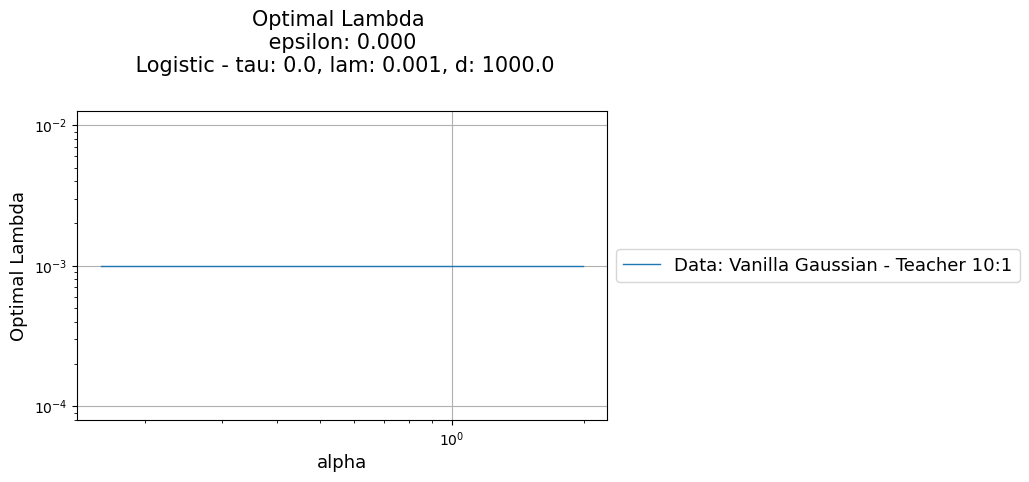

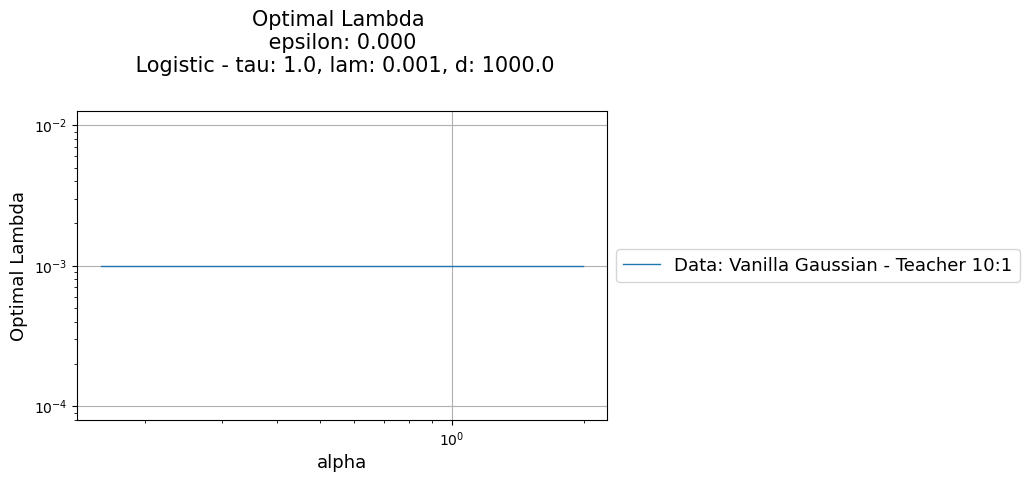

In [451]:
create_plot(df,"Optimal Lambda", "lam", None)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52547/3750336112.py:148: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


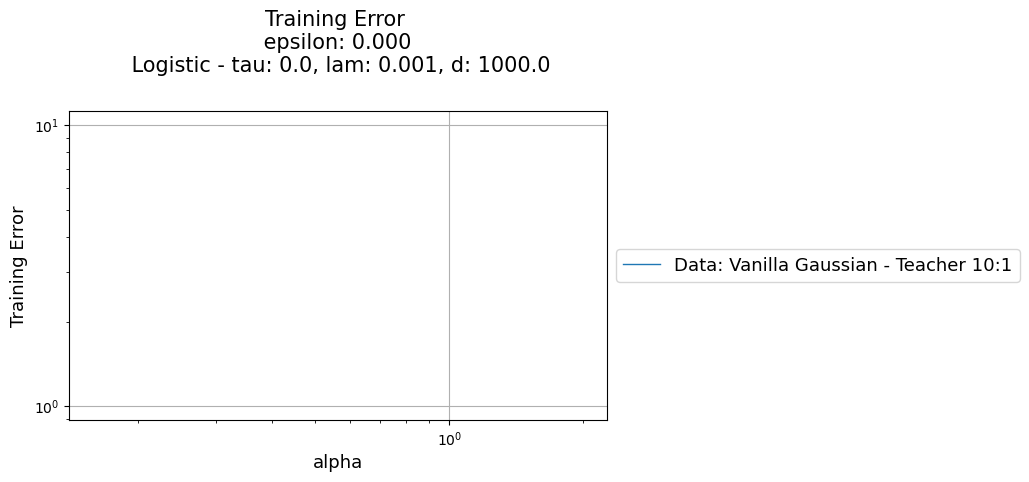

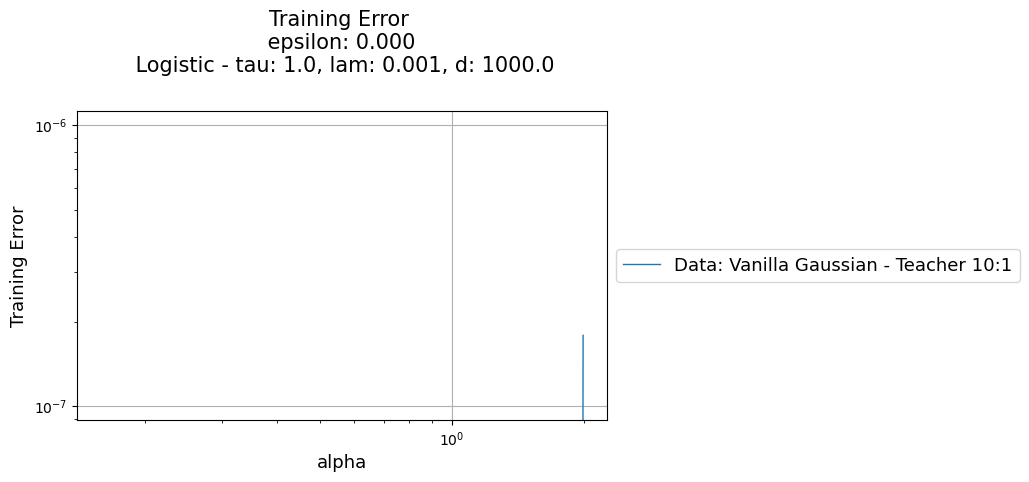

In [452]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm")

In [453]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

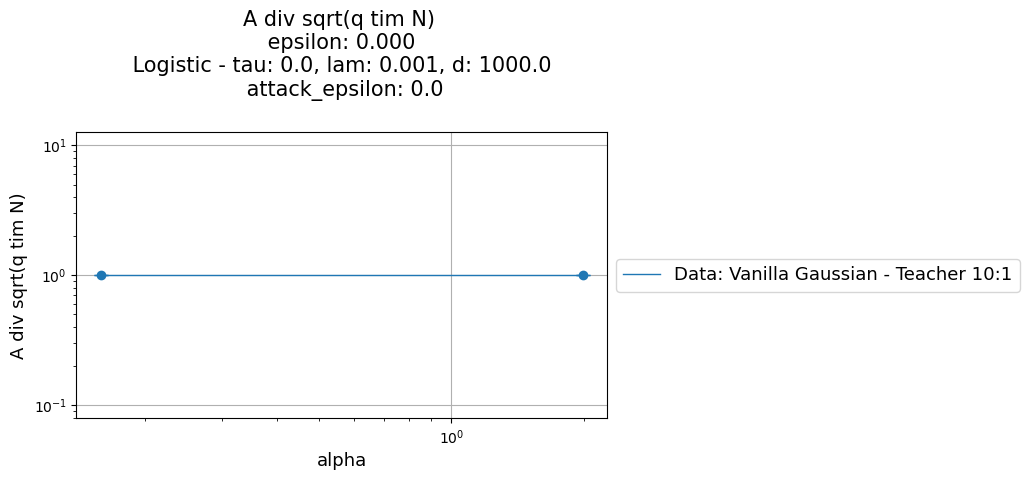

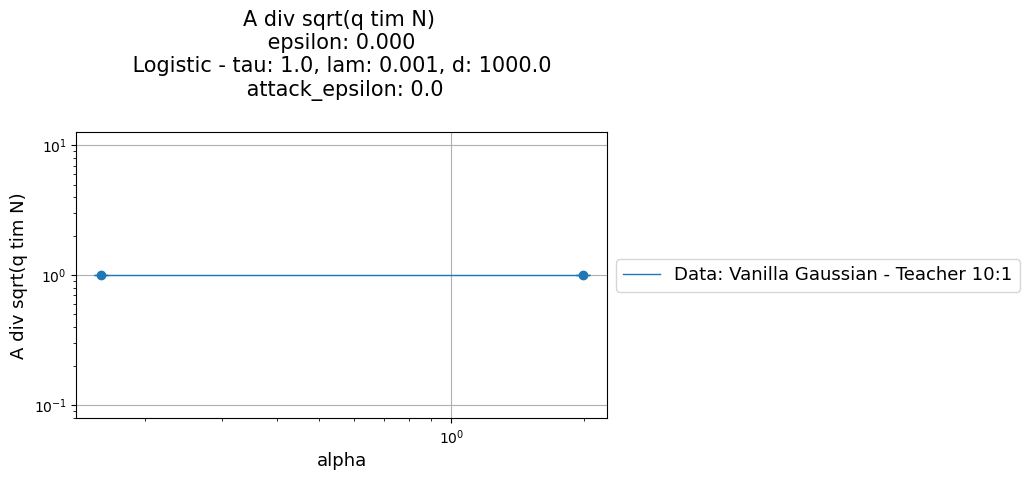

In [454]:

create_plot(df, "A div sqrt(q tim N)", "A_over_sqrt_qN_state_evolution", "A_over_sqrt_qN_erm",plot_attack_epsilon=True)

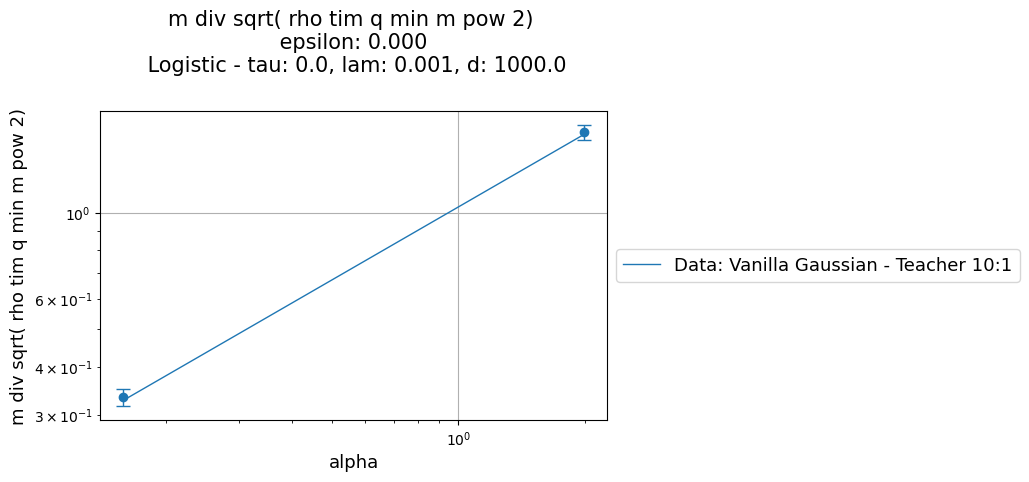

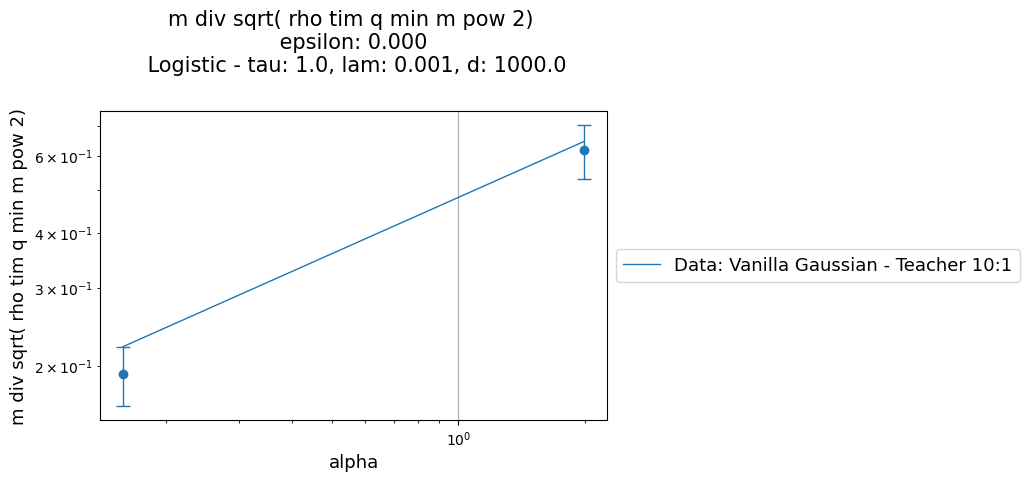

In [455]:
create_plot(df, "m div sqrt( rho tim q min m pow 2)", "m_over_sqrt_rhoq_minus_m2_state_evolution", "m_over_sqrt_rhoq_minus_m2_erm")

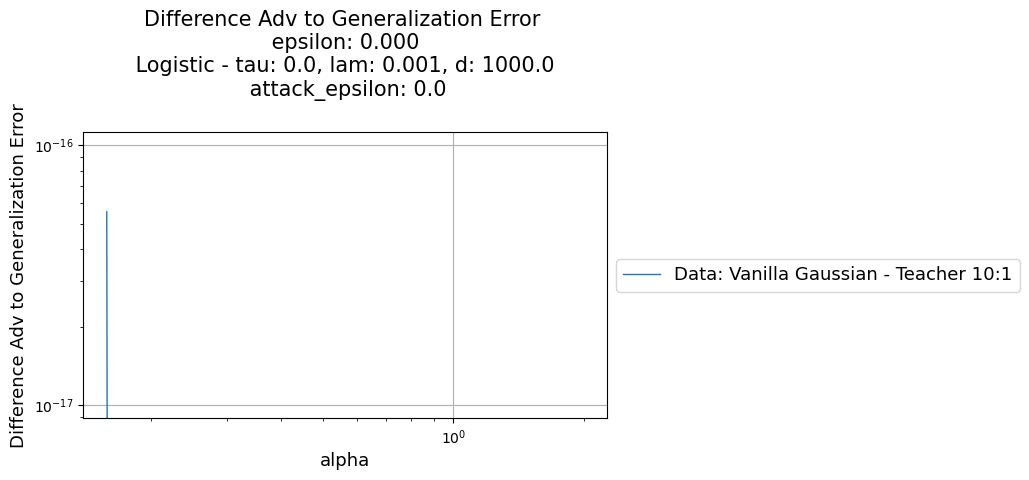

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52547/3750336112.py:148: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


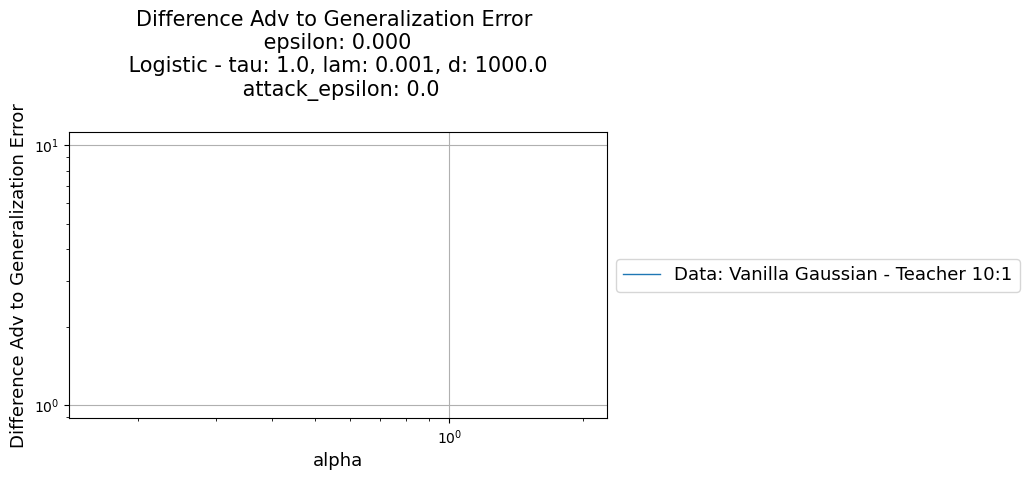

In [456]:
create_plot(df, "Difference Adv to Generalization Error", "difference_adv_gen_state_evolution", "difference_adv_gen_erm",plot_attack_epsilon=True)


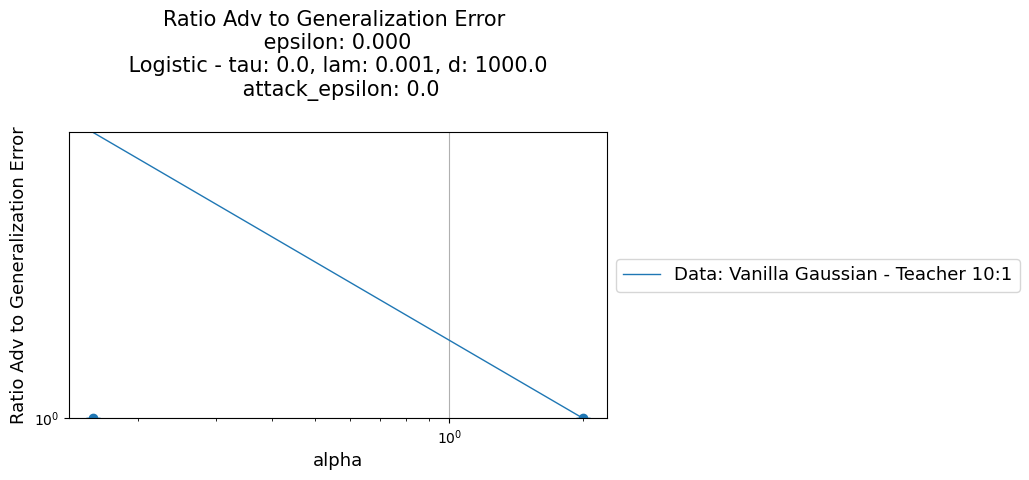

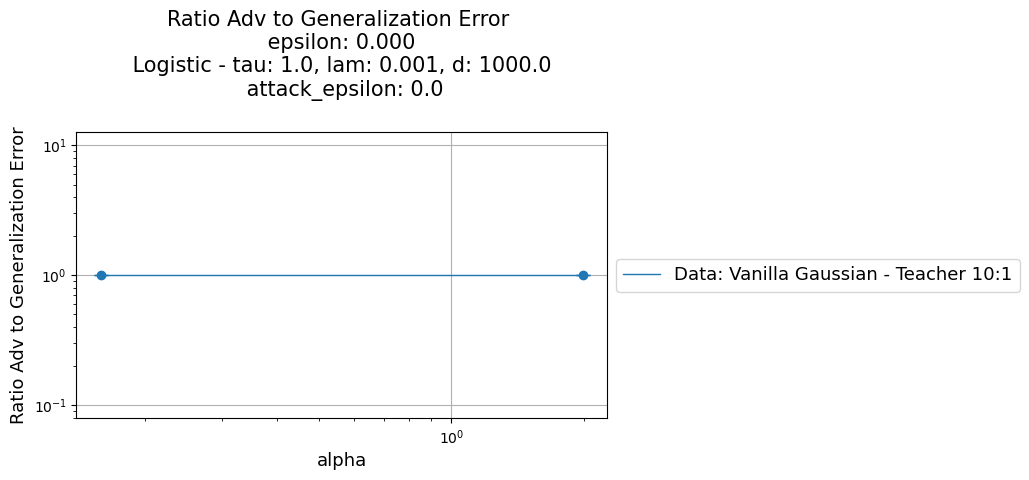

In [457]:
create_plot(df, "Ratio Adv to Generalization Error", "ratio_adv_gen_state_evolution", "ratio_adv_gen_erm",plot_attack_epsilon=True)

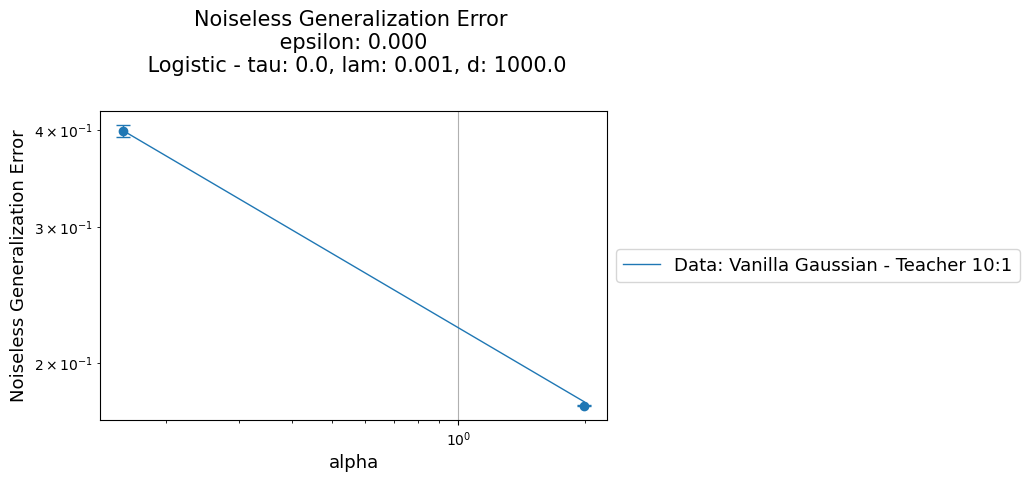

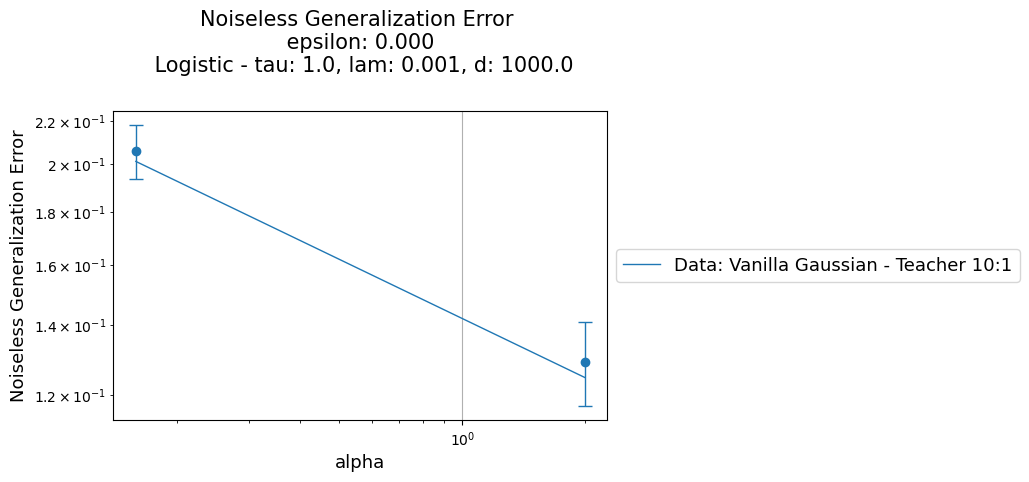

In [458]:
create_plot(df, "Noiseless Generalization Error", "noiseless_generalization_error_state_evolution", "noiseless_generalization_error_erm_erm", log_y=True)

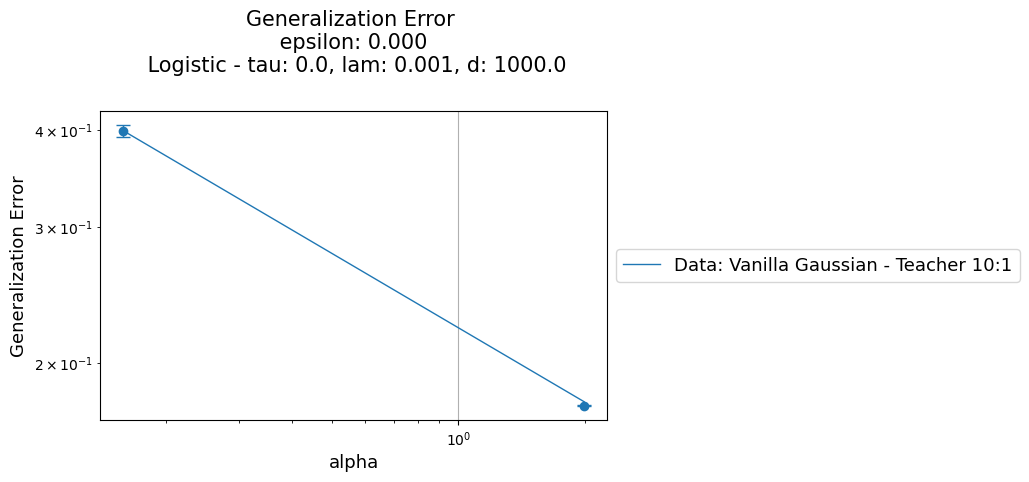

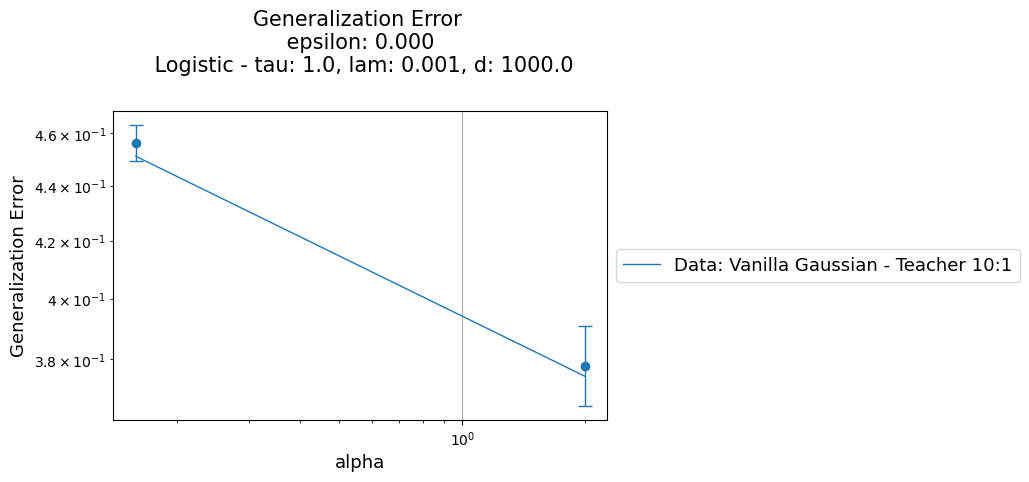

In [459]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

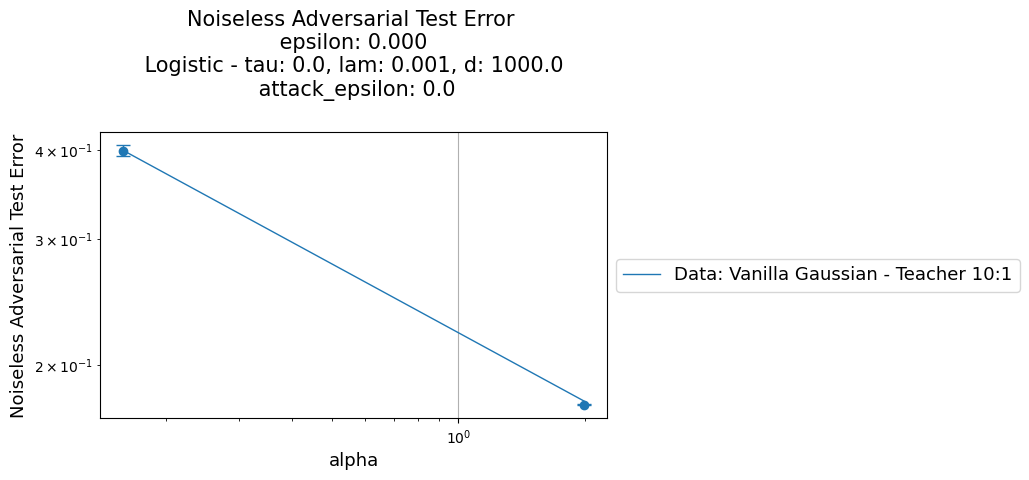

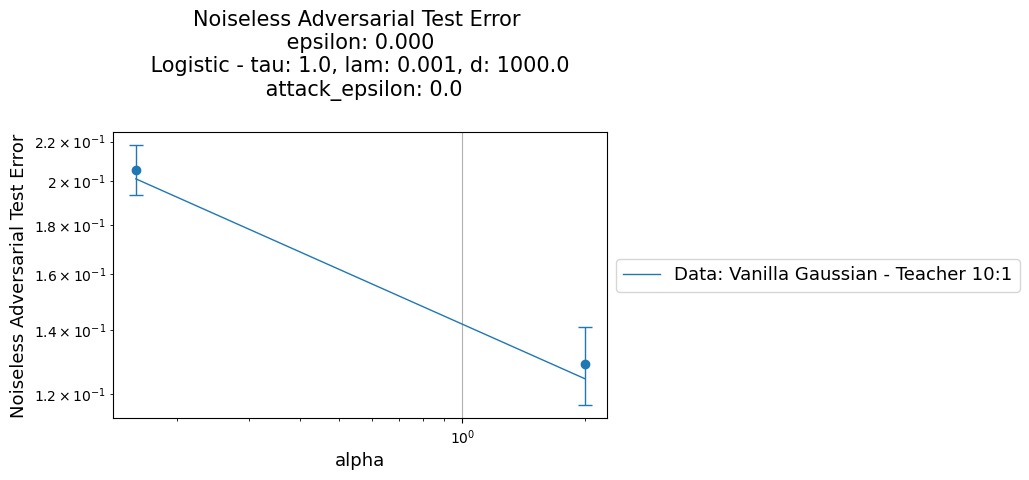

In [460]:
create_plot(df, "Noiseless Adversarial Test Error", "noiseless_adversarial_generalization_error_state_evolution", "noiseless_adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

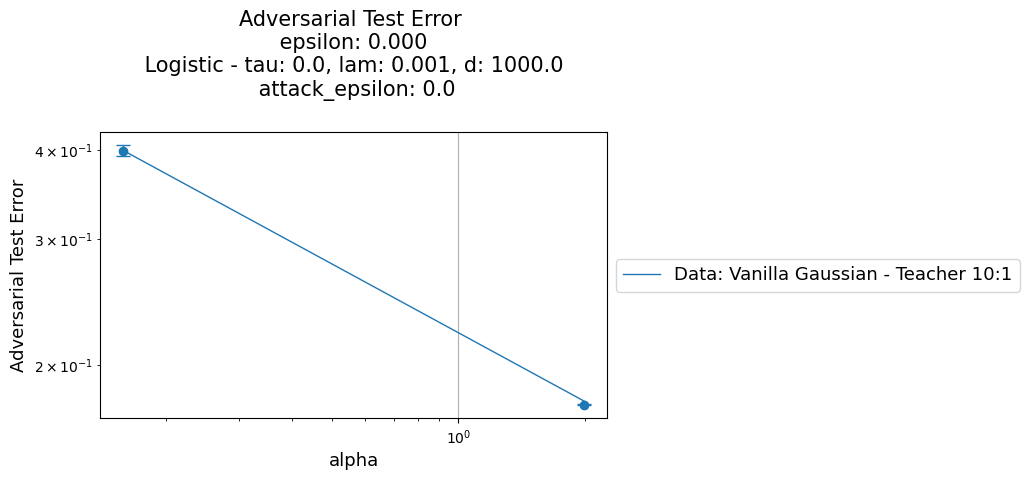

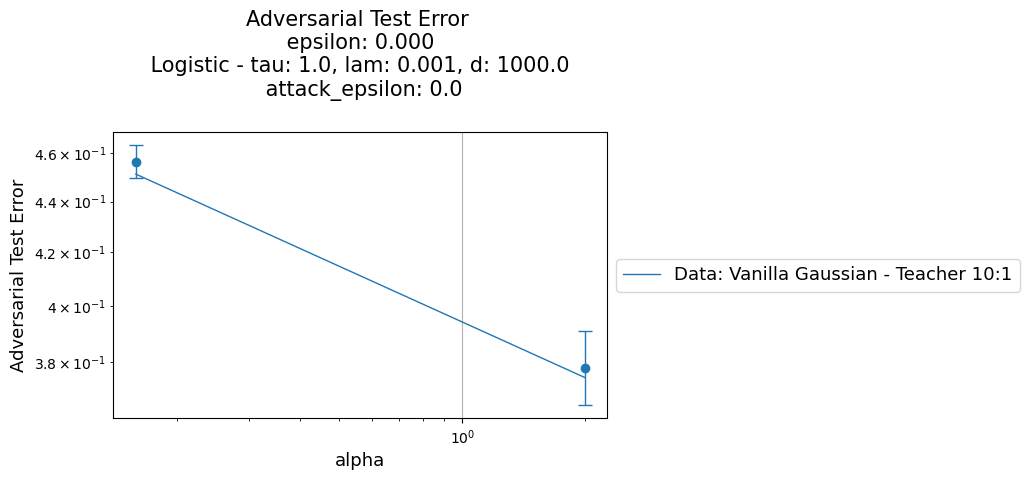

In [461]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_52547/3750336112.py:148: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


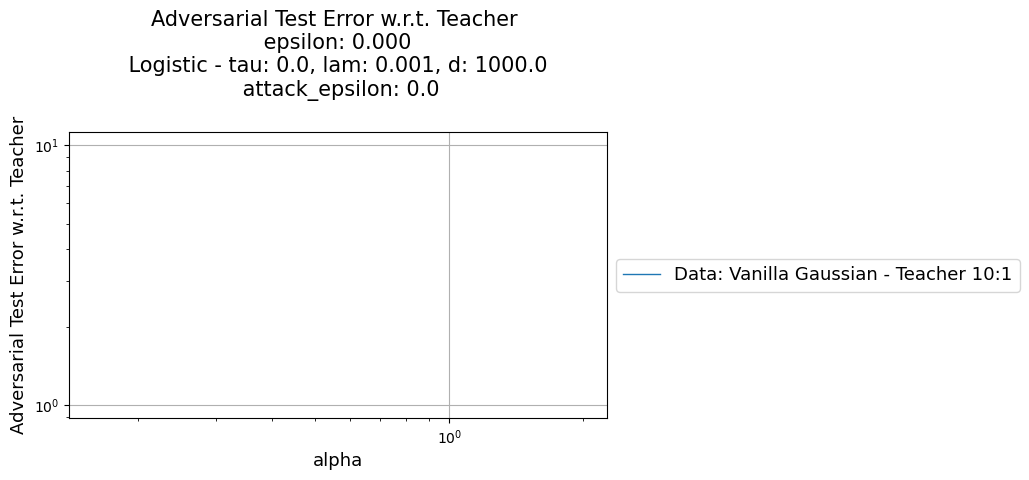

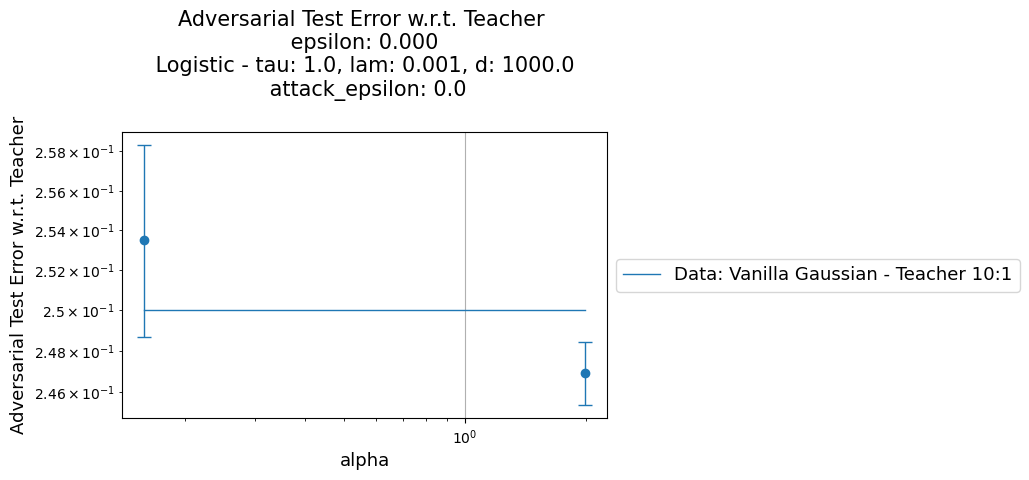

In [462]:
create_plot(df, "Adversarial Test Error w.r.t. Teacher", "adversarial_generalization_error_teacher_state_evolution", "adversarial_generalization_error_teacher_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

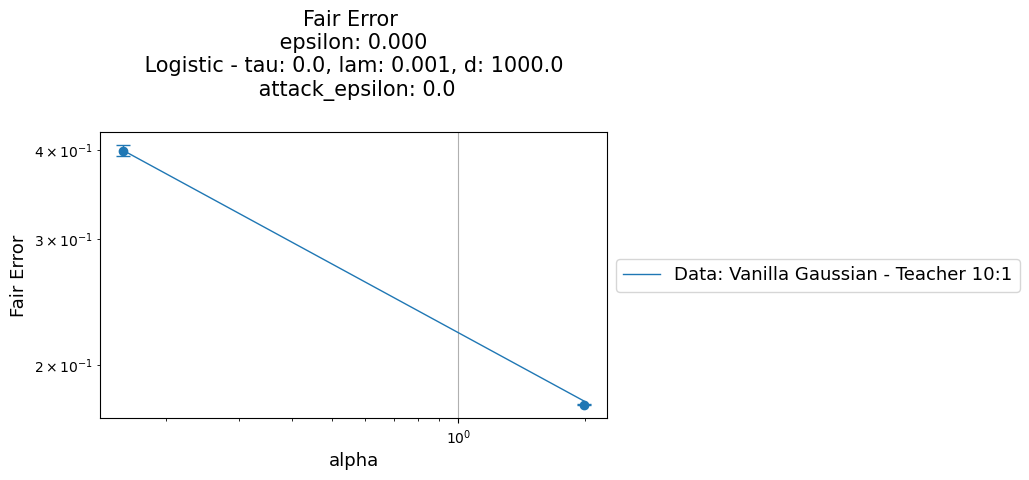

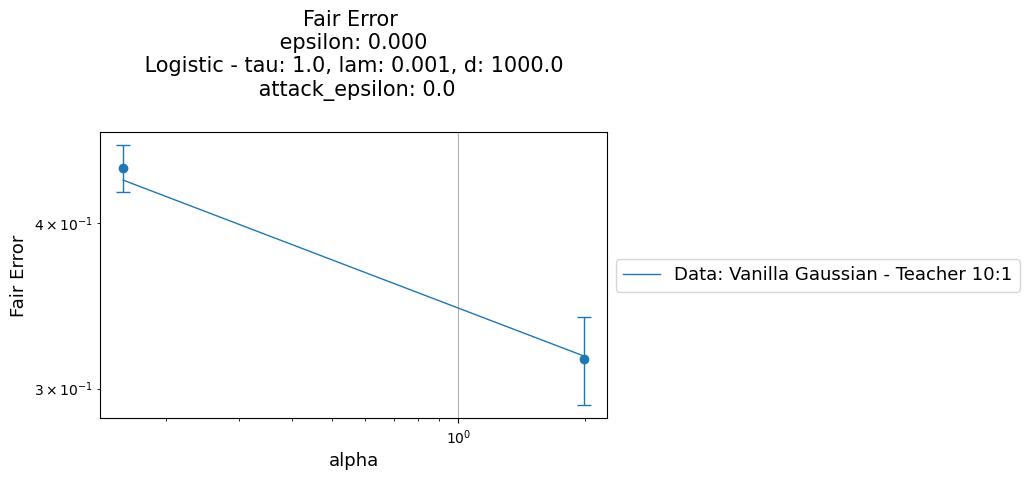

In [463]:
# plot the fair adversarial error
create_plot(df, "Fair Error", "fair_adversarial_error_state_evolution","fair_adversarial_error_erm",plot_attack_epsilon=True)

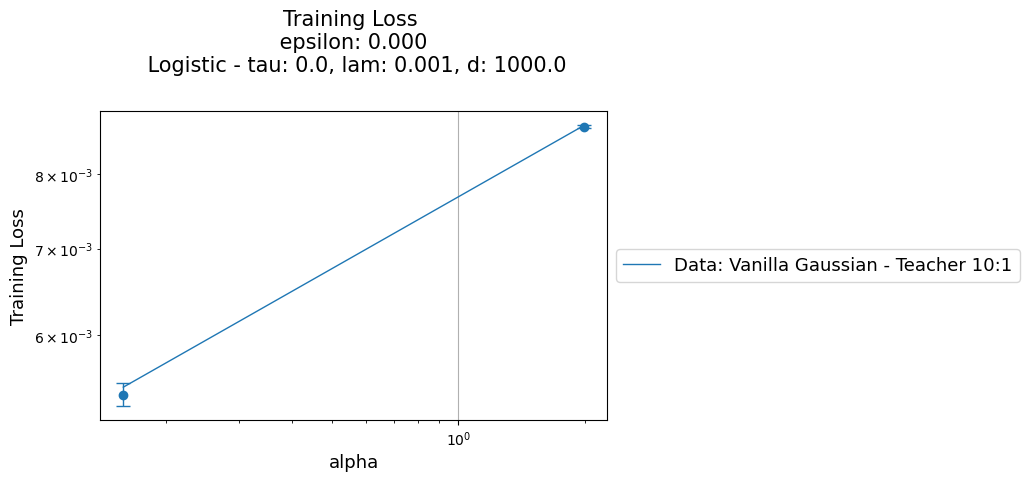

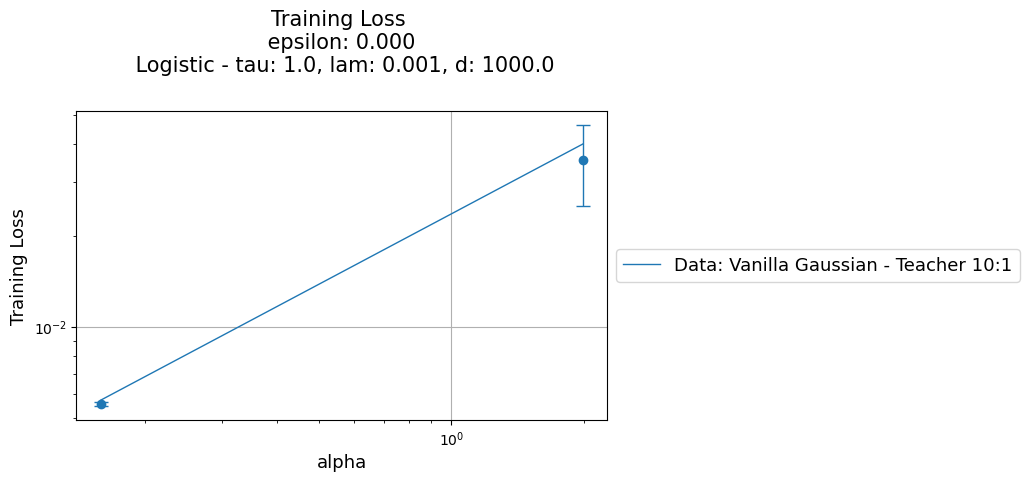

In [464]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

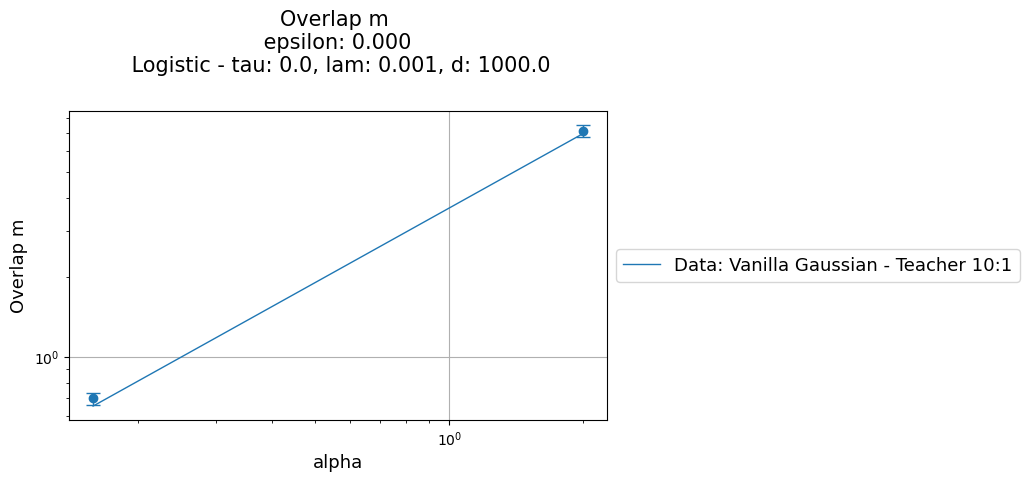

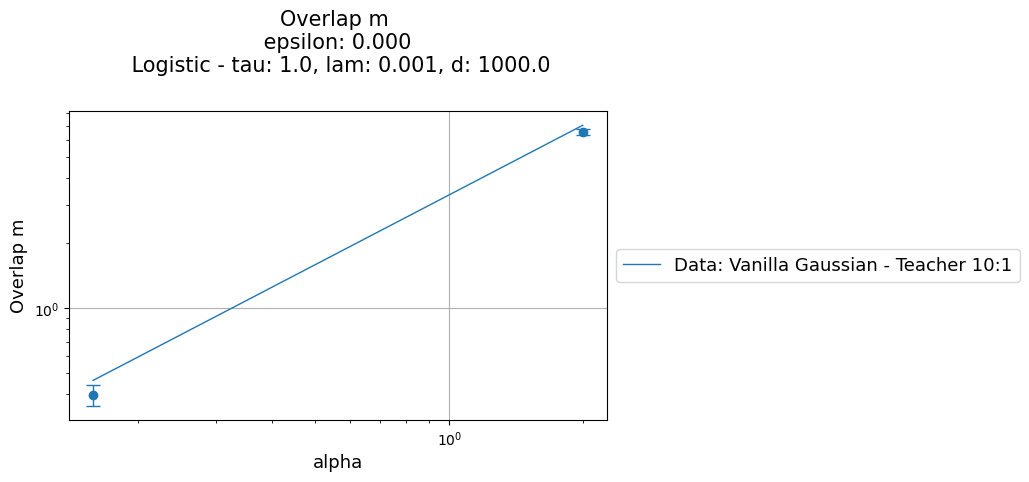

In [465]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm")

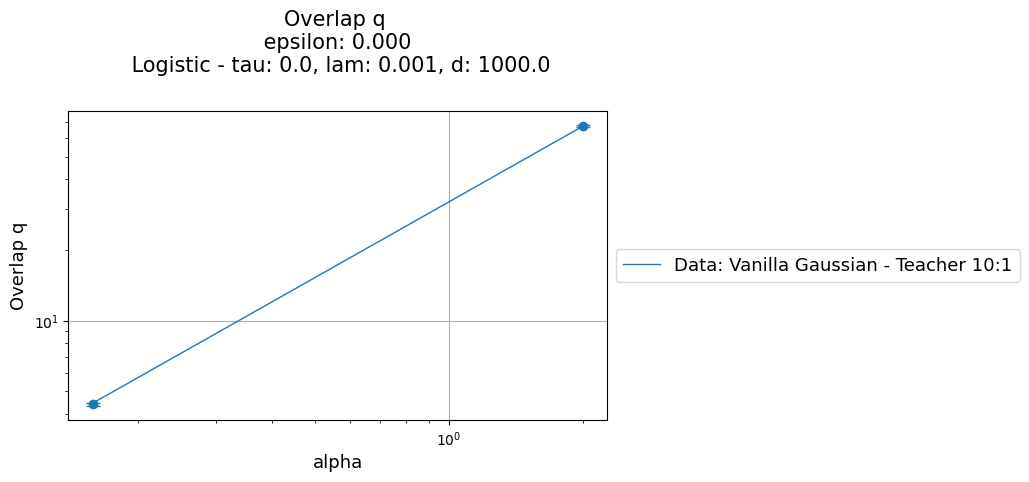

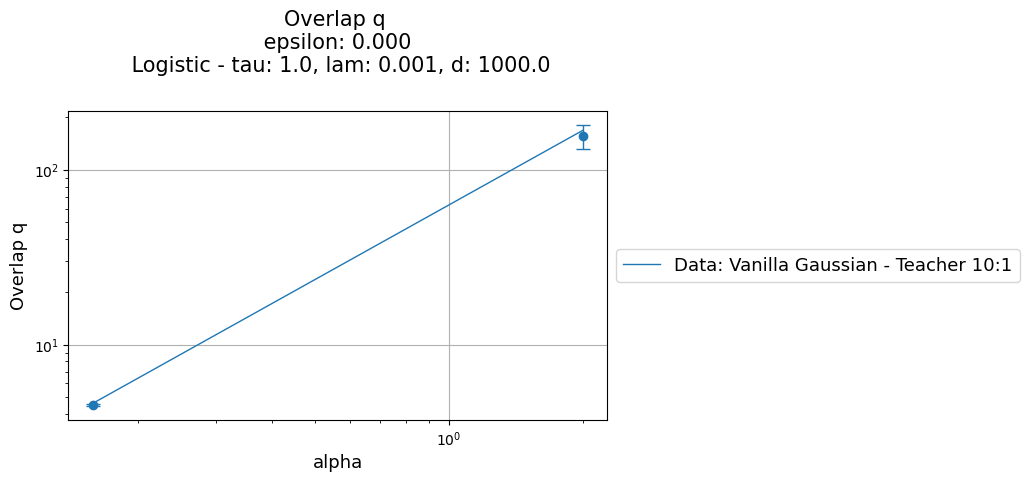

In [466]:
create_plot(df, "Overlap q", "q_state_evolution","q_erm", log_y=True)

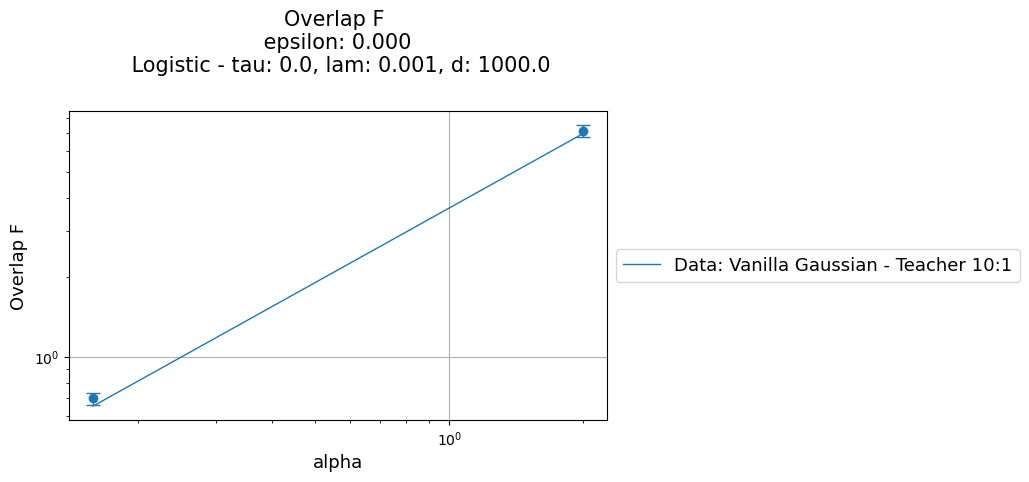

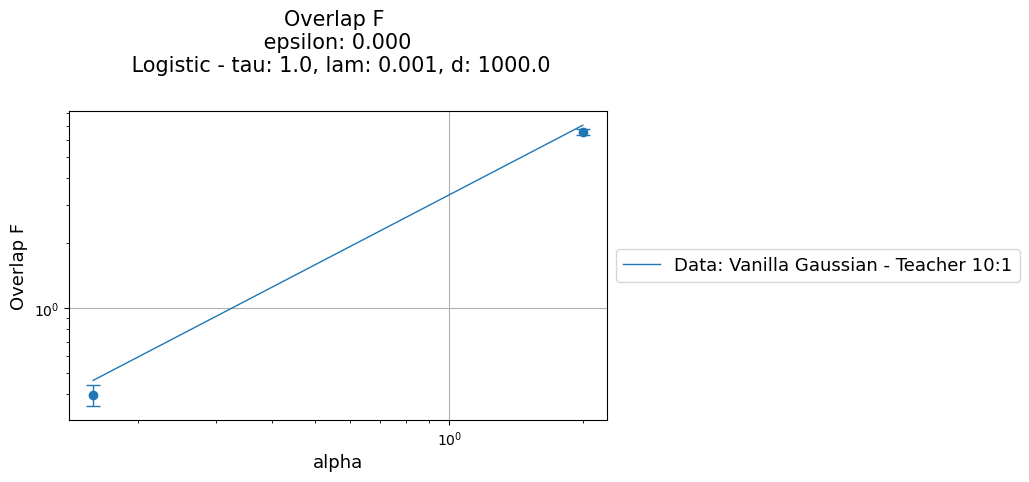

In [467]:
# Plot the F overlap
create_plot(df, "Overlap F", "F_state_evolution","F_erm", log_y=True)

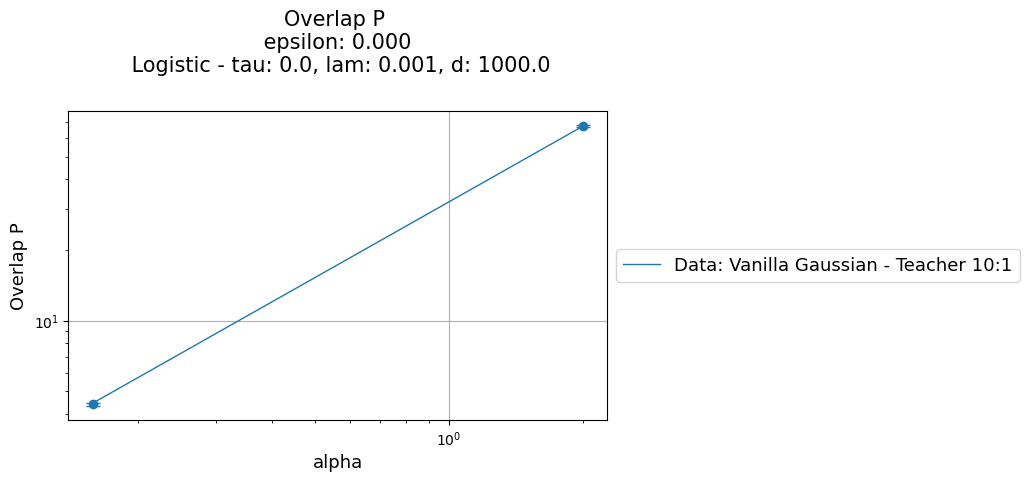

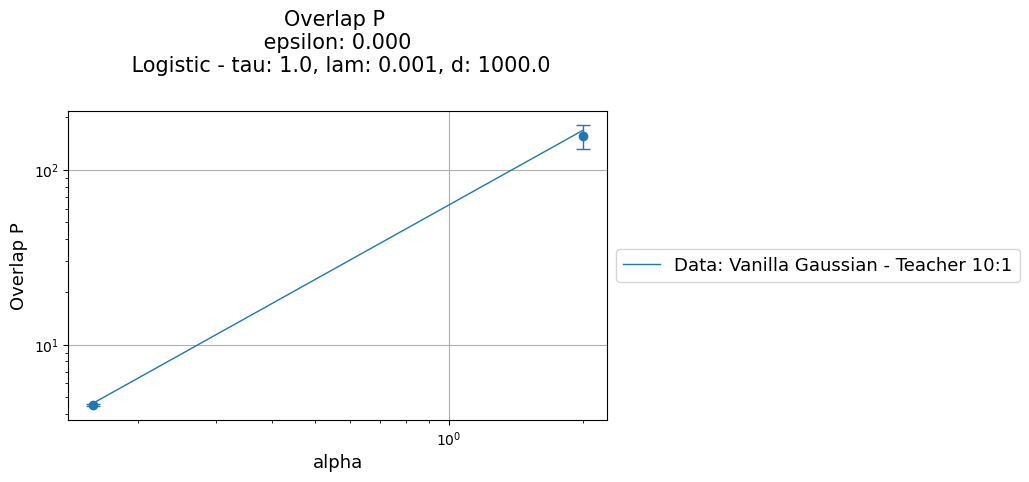

In [468]:
# Plot the P overlap
create_plot(df, "Overlap P", "P_state_evolution","P_erm", log_y=True)

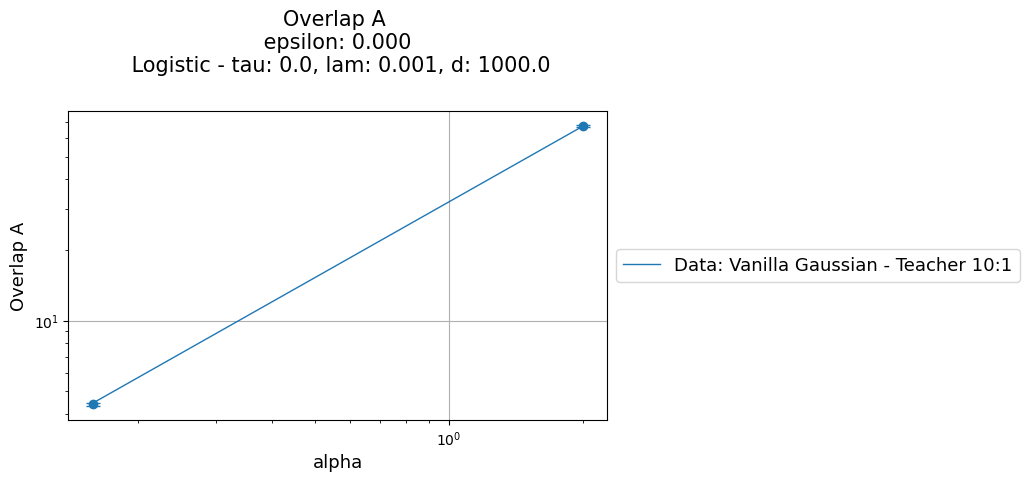

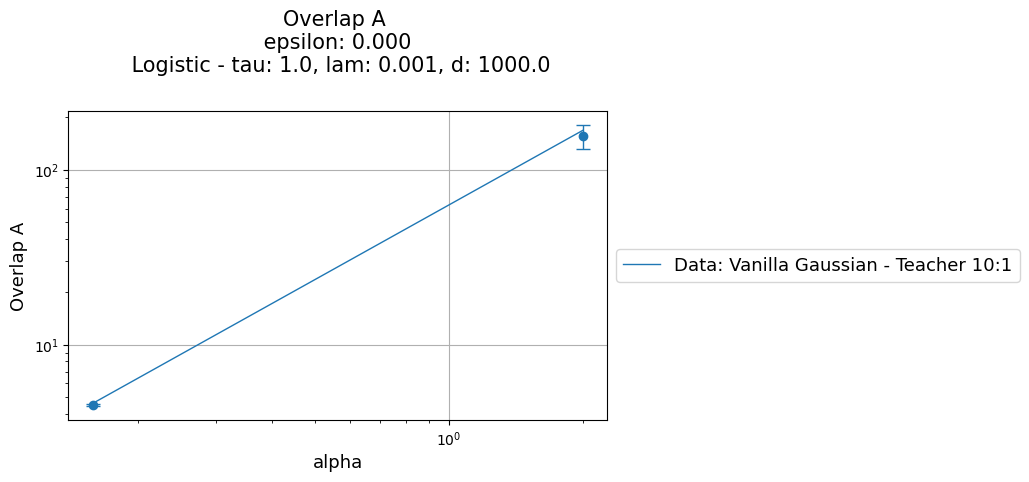

In [469]:
# Plot the A overlap
create_plot(df, "Overlap A", "A_state_evolution","A_erm", log_y=True)

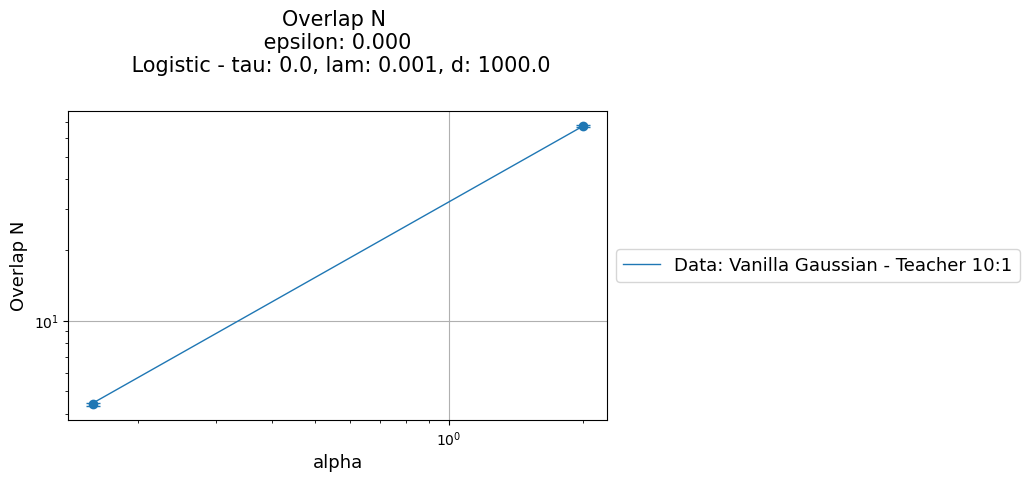

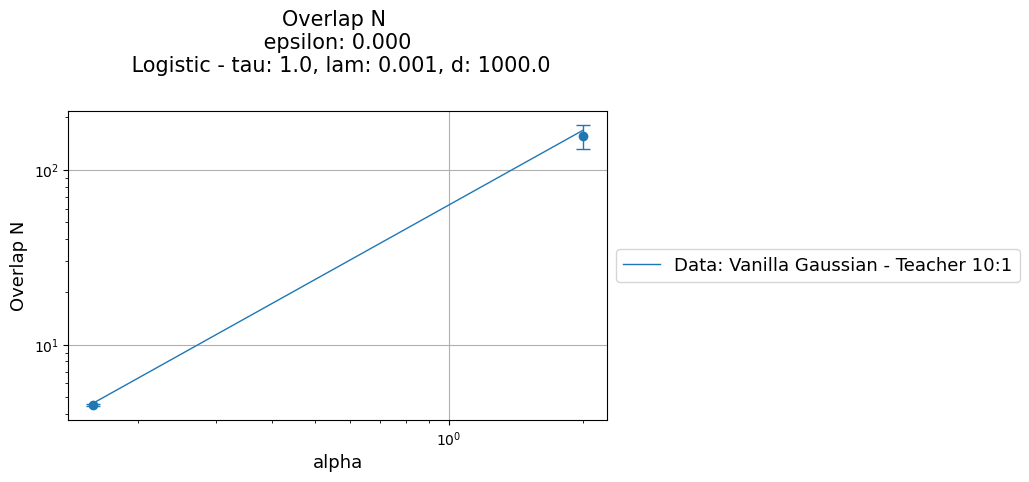

In [470]:
# Plot the N overlap
create_plot(df, "Overlap N", "N_state_evolution","N_erm", log_y=True)

In [471]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

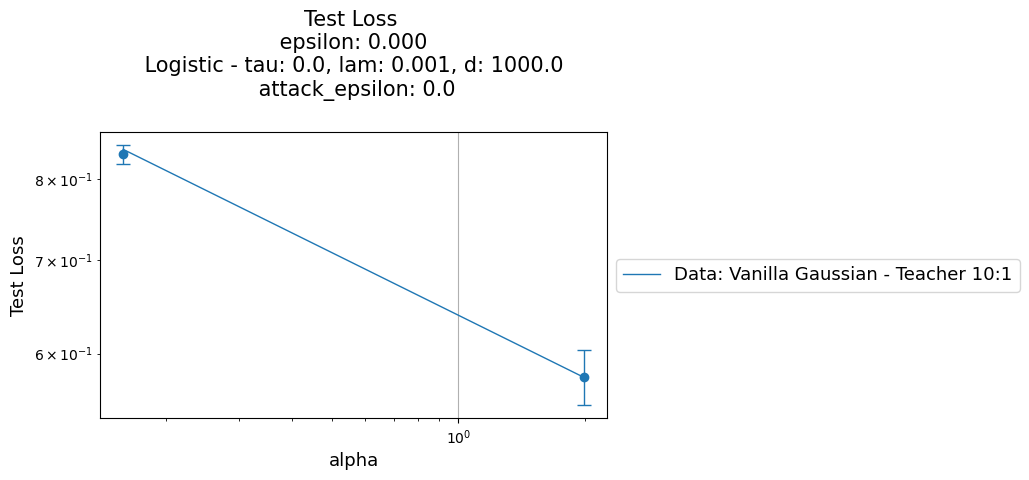

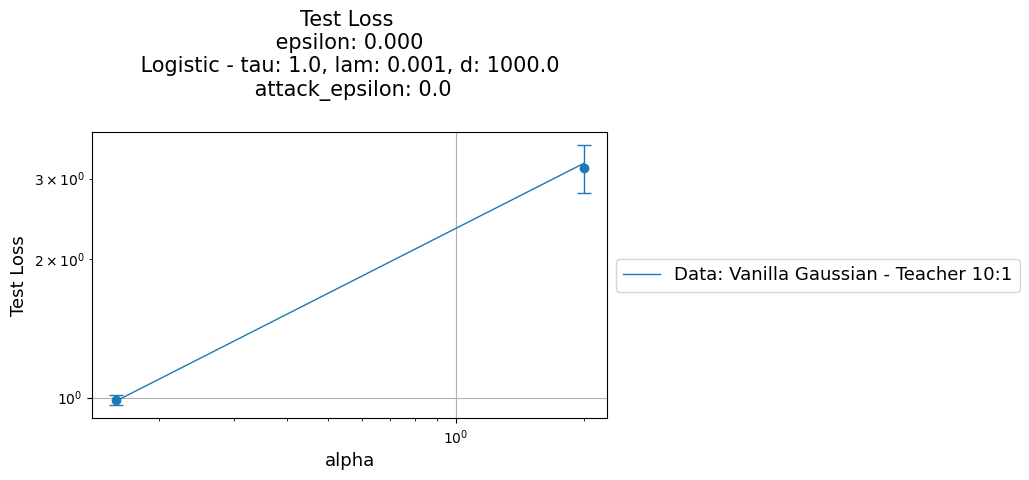

In [472]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True,plot_attack_epsilon=True)

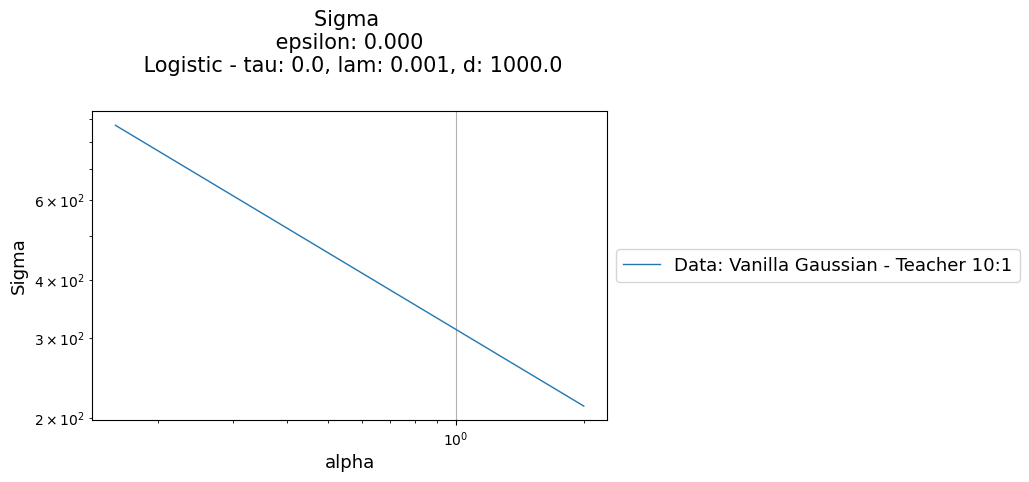

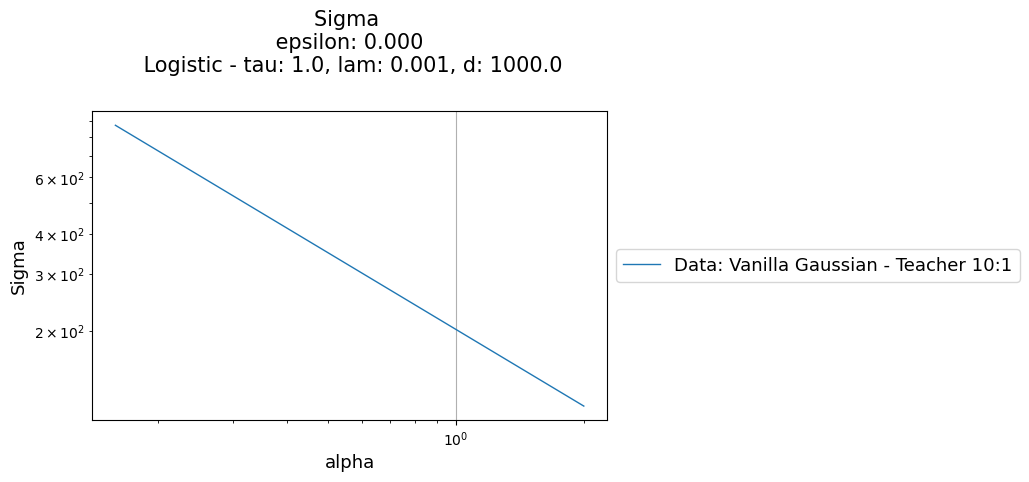

In [473]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None)

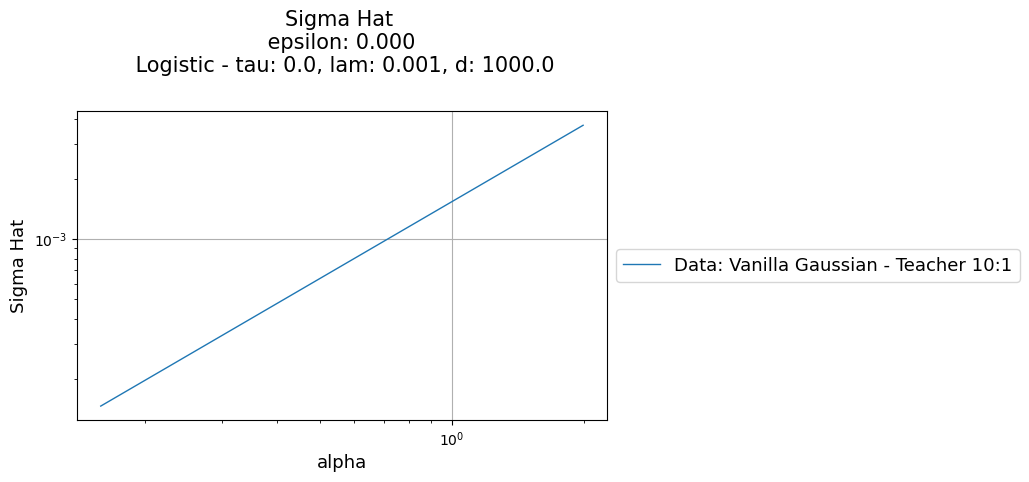

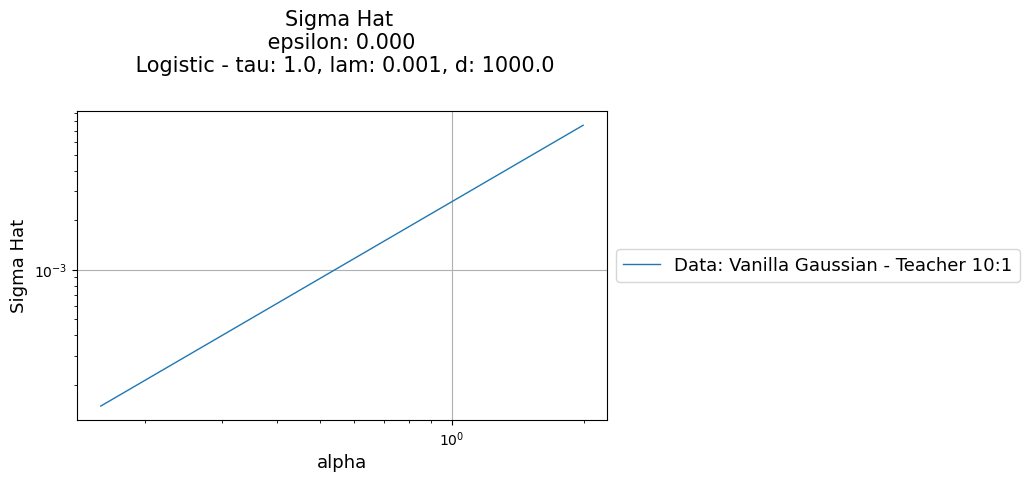

In [474]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None)

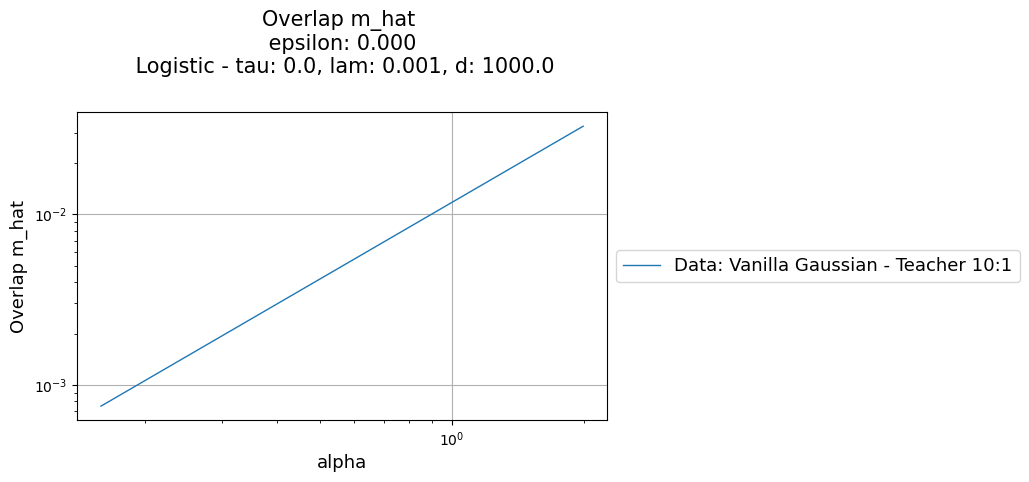

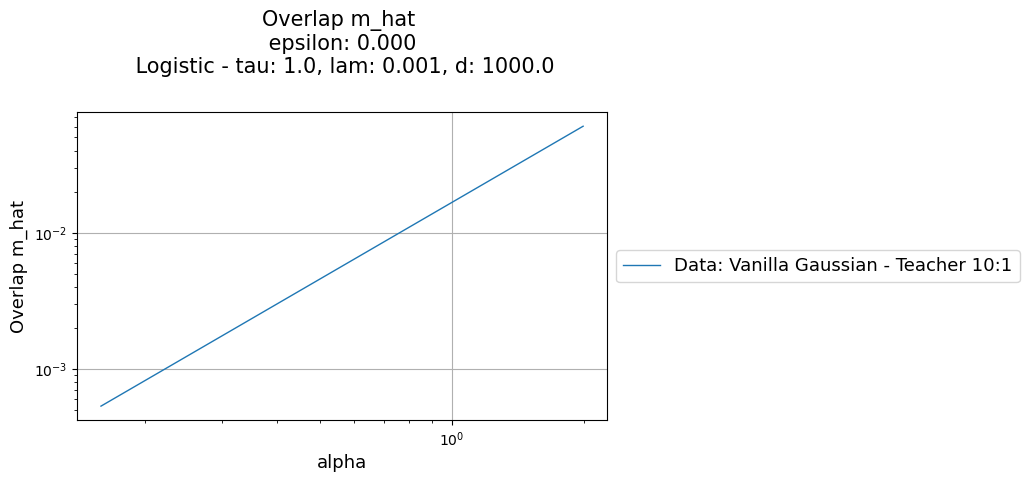

In [475]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None)

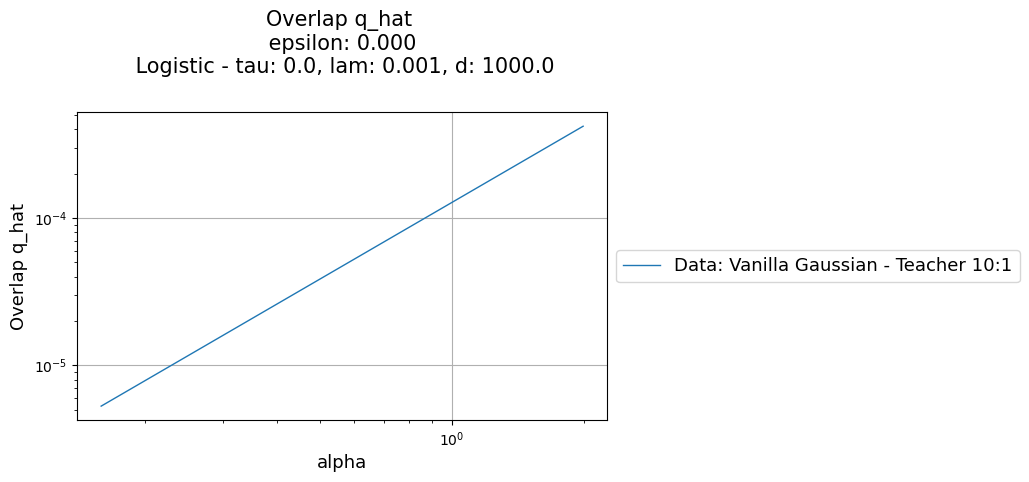

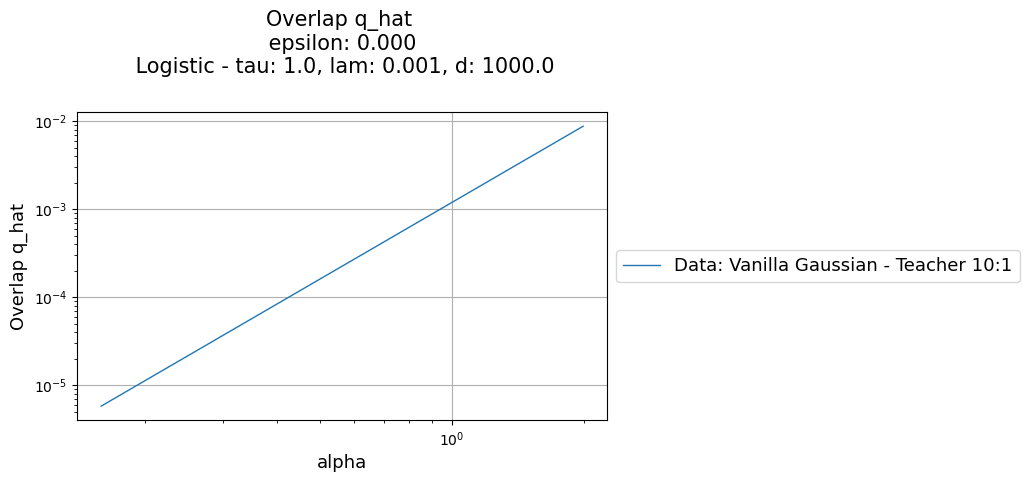

In [476]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None)

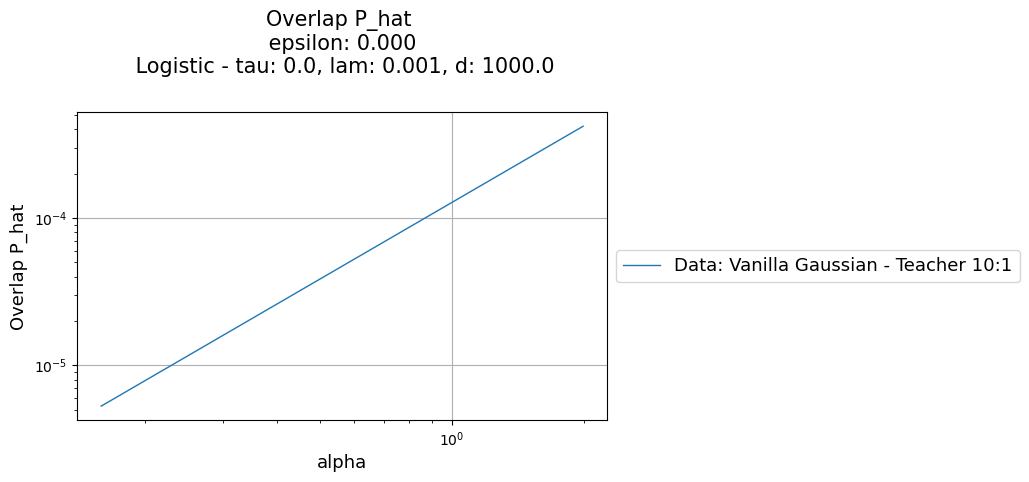

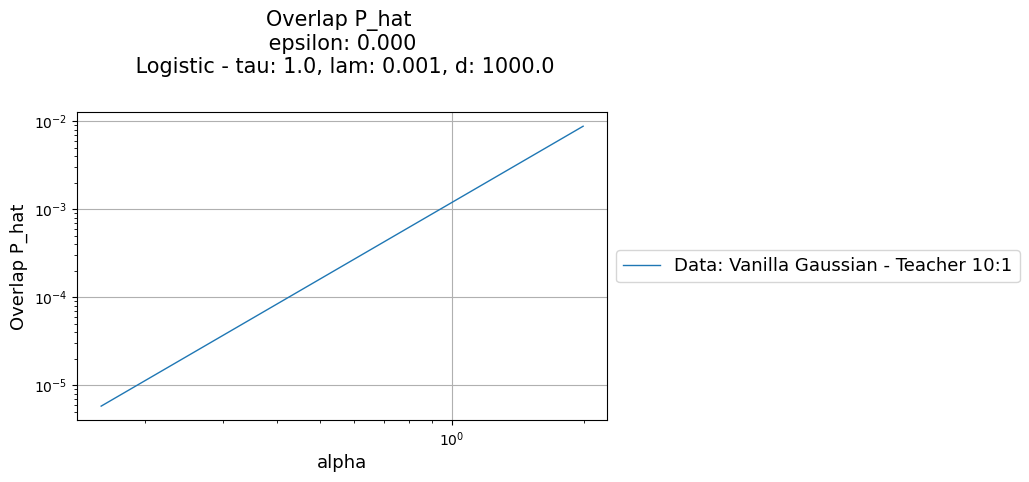

In [477]:
create_plot(df, "Overlap P_hat", "q_hat_state_evolution", None)

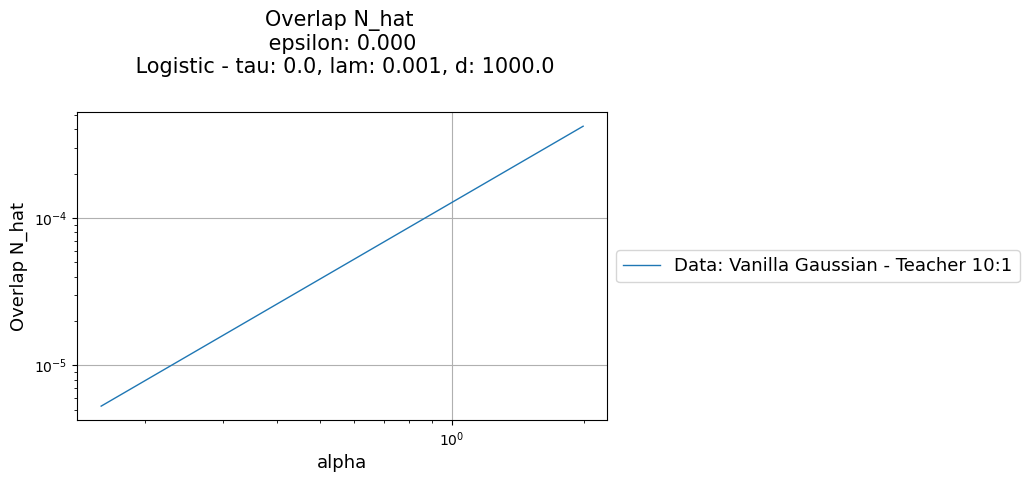

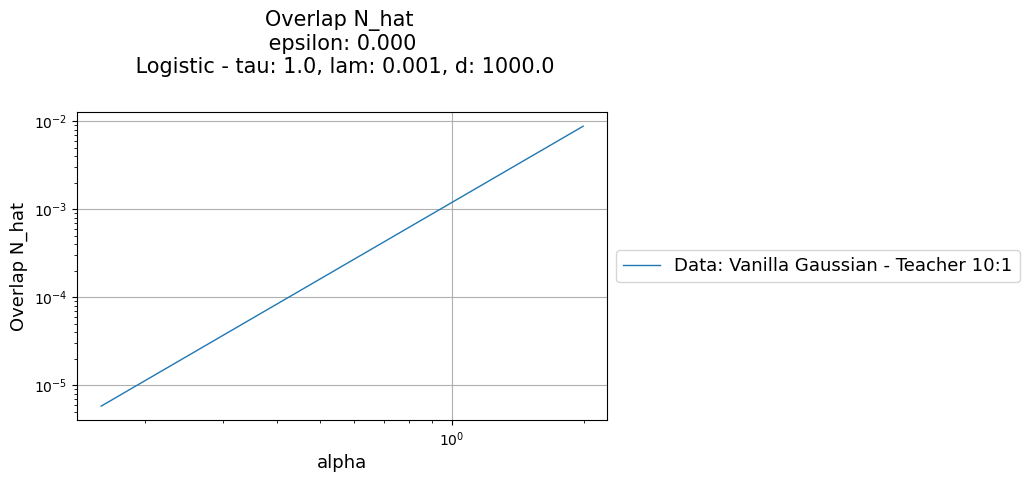

In [478]:
create_plot(df, "Overlap N_hat", "q_hat_state_evolution", None)

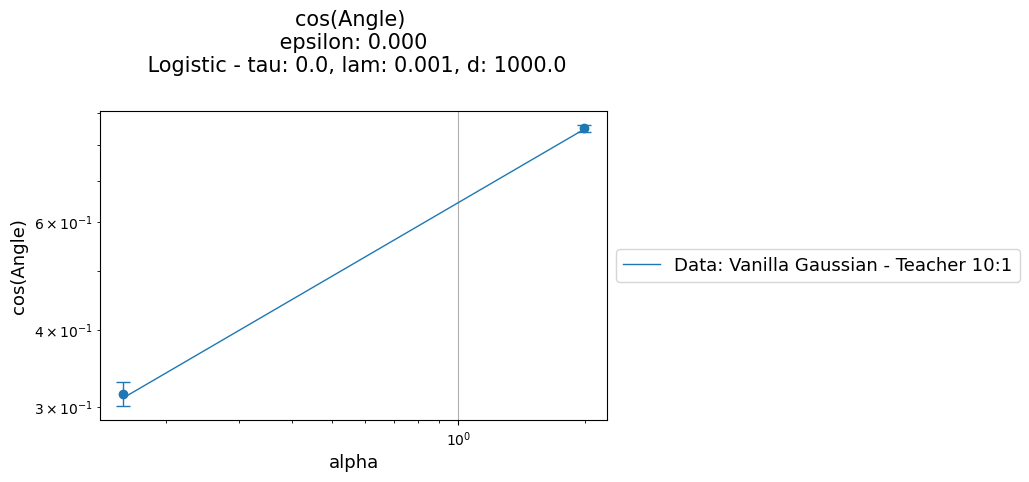

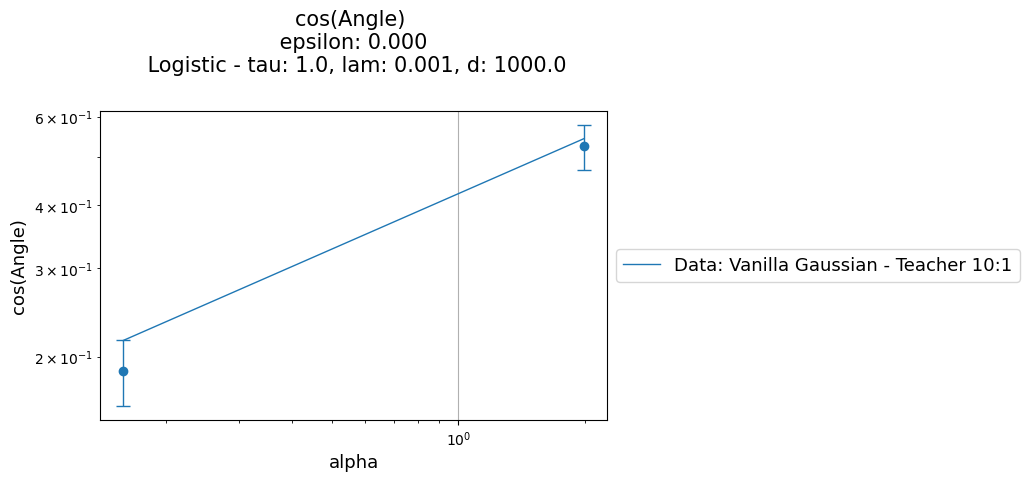

In [479]:
create_plot(df, "cos(Angle)", "angle_state_evolution","angle_erm")

# Plot the subspace overlaps

In [480]:
experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])

In [481]:
experiment.data_model_types

[<DataModelType.KFeaturesModel: 5>]

In [482]:
# data_models = experiment.load_data_models(logger, source_pickle_path="./")

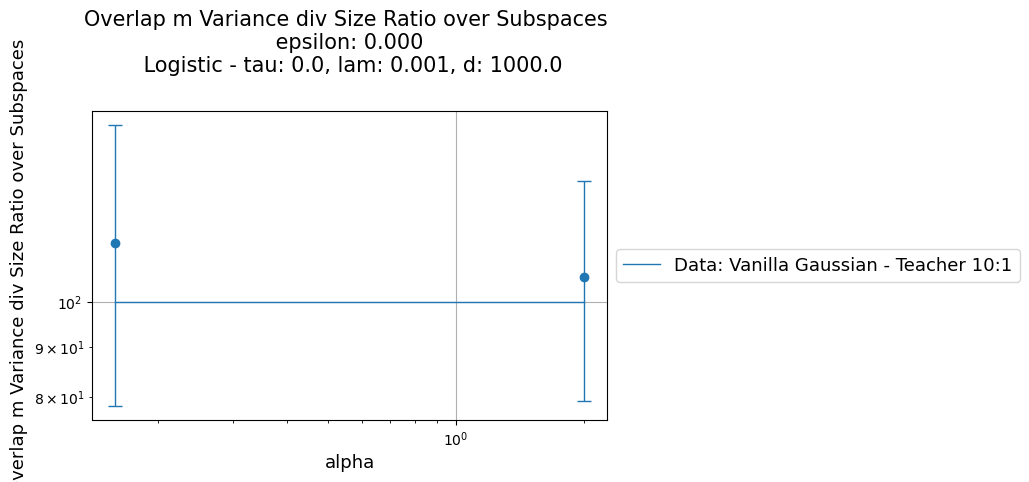

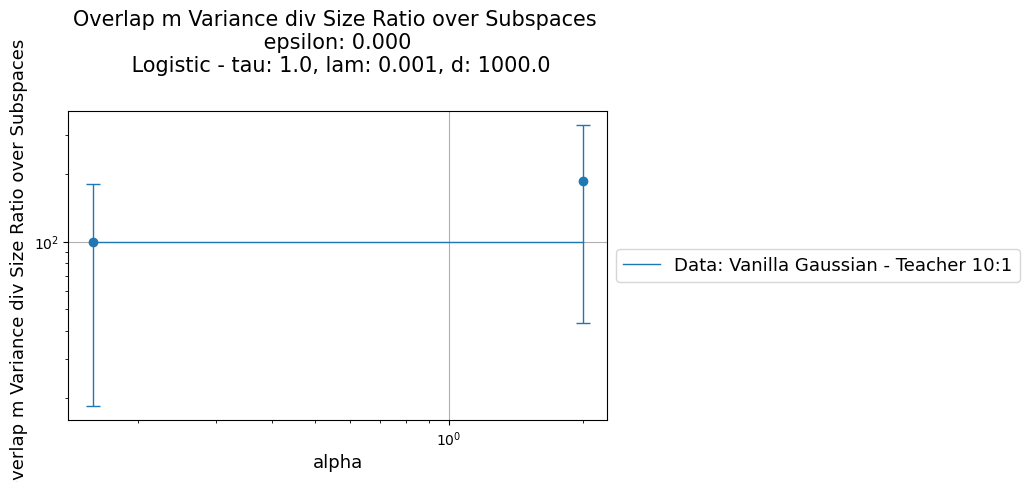

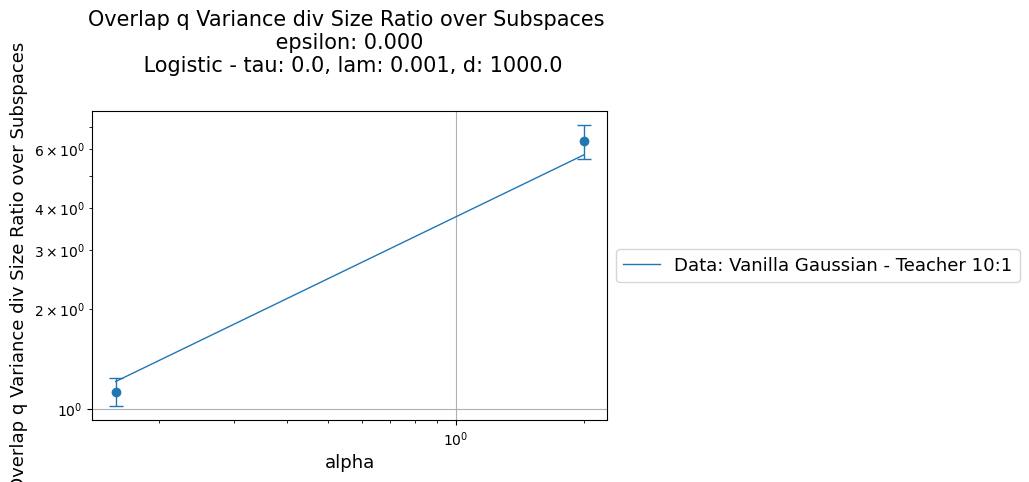

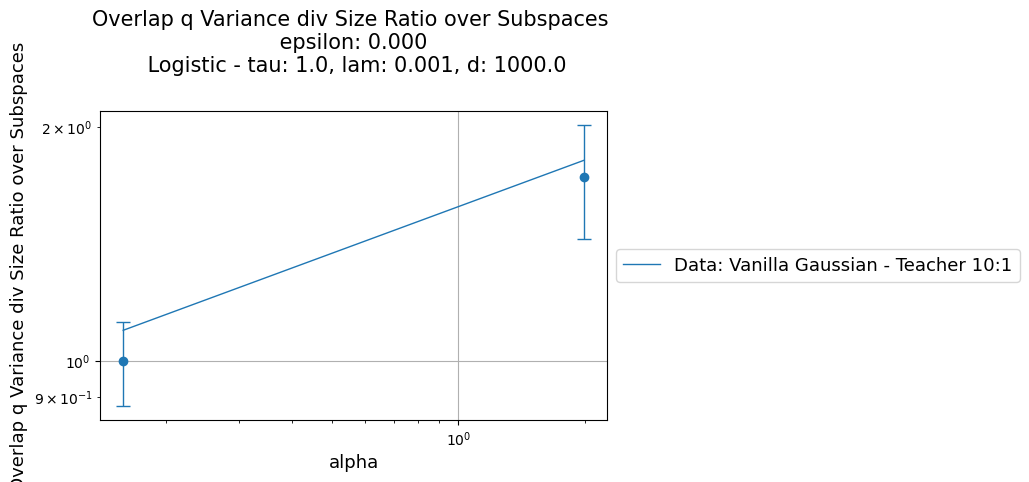

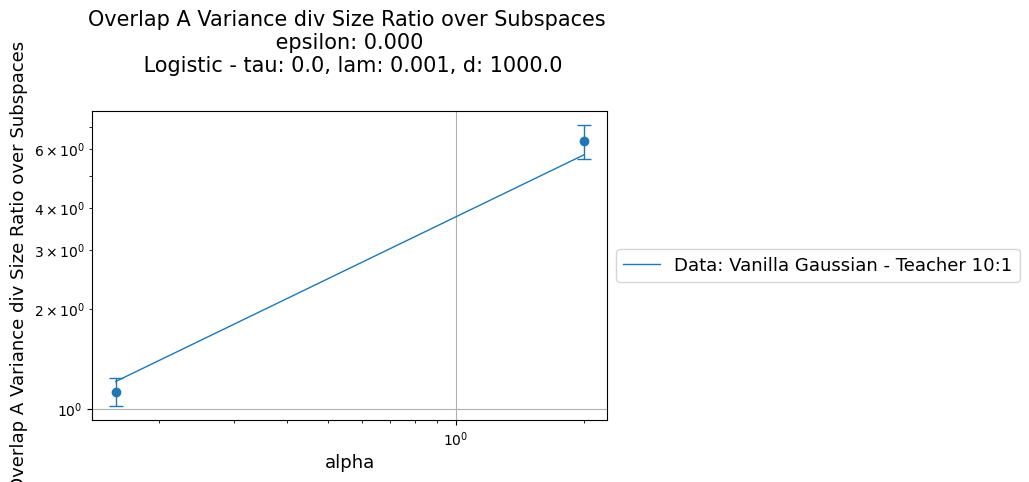

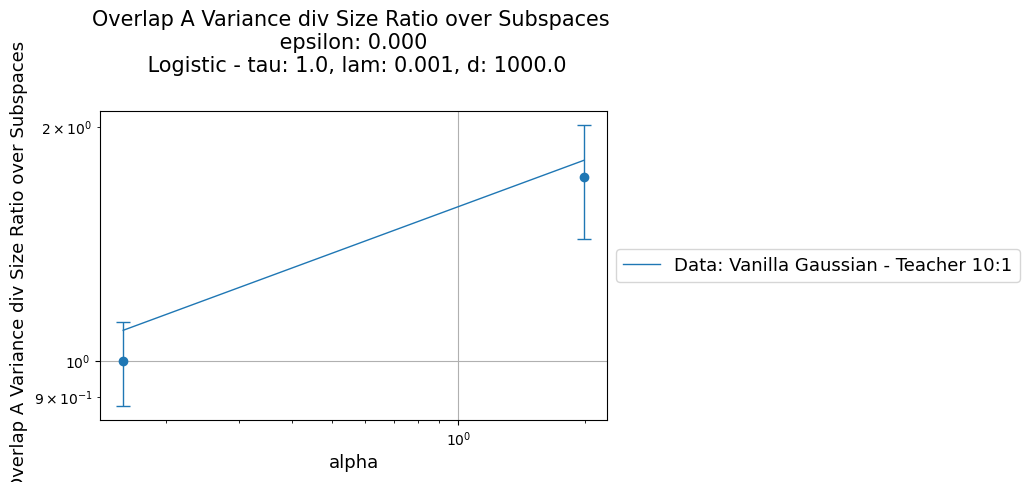

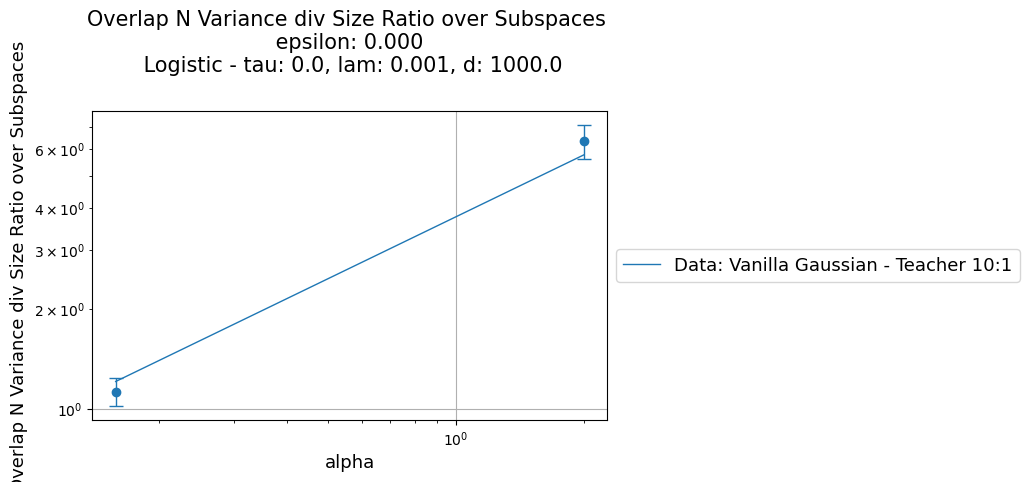

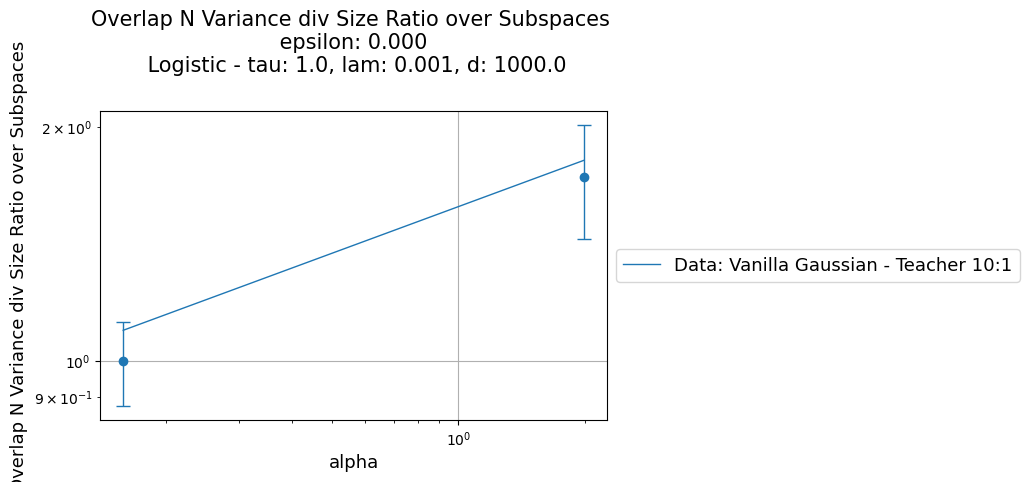

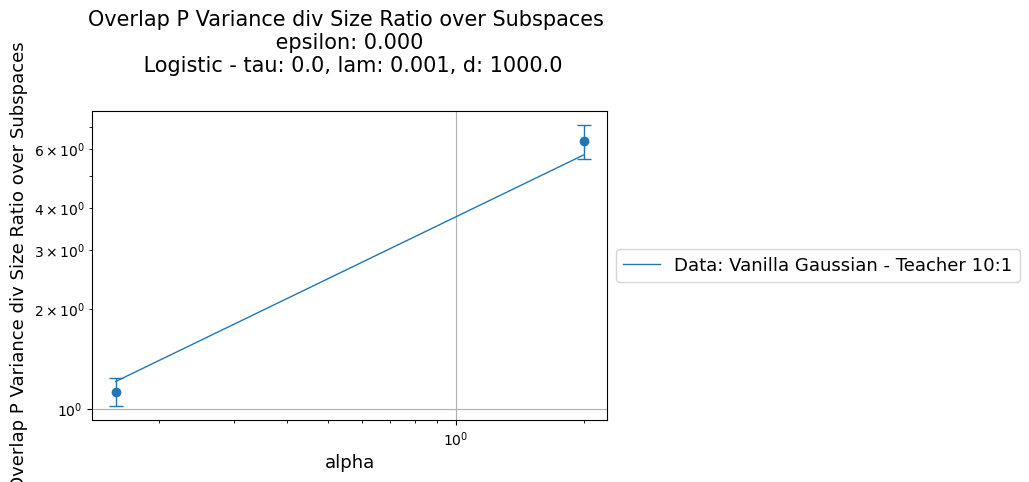

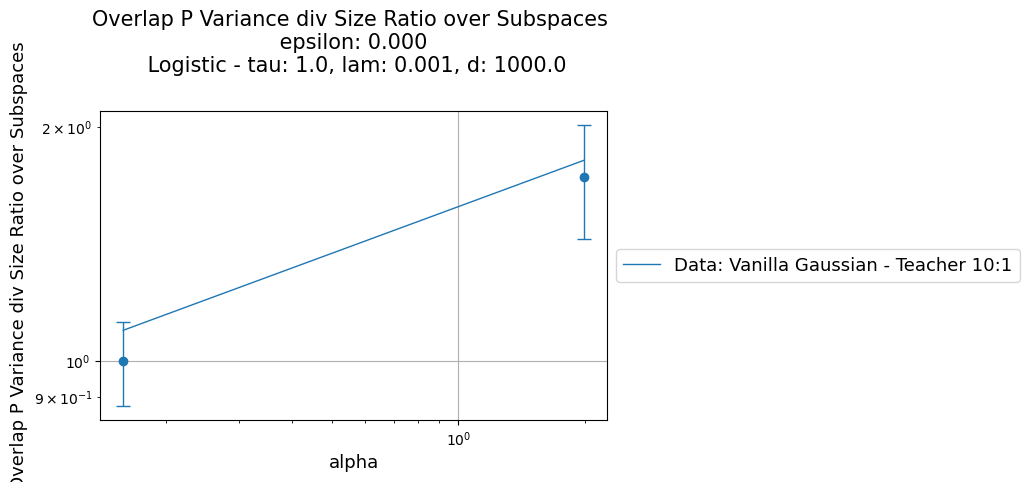

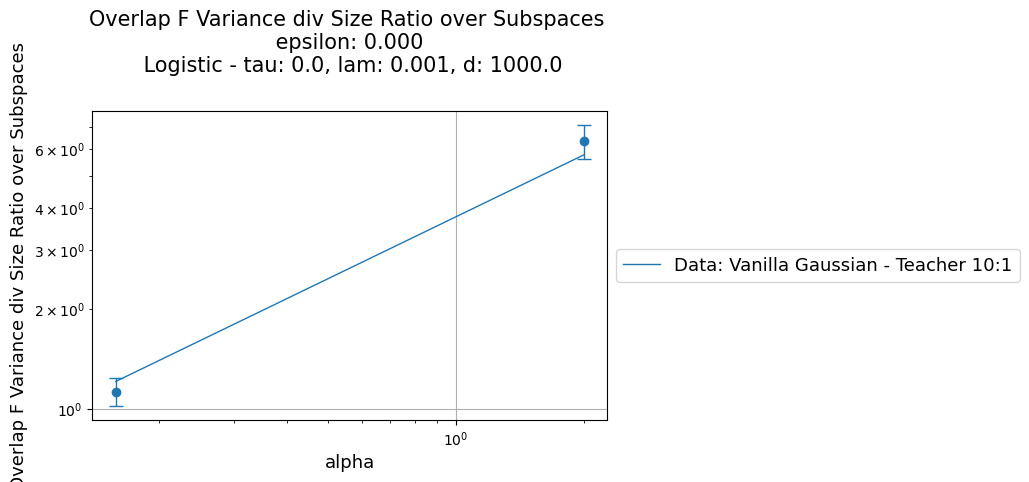

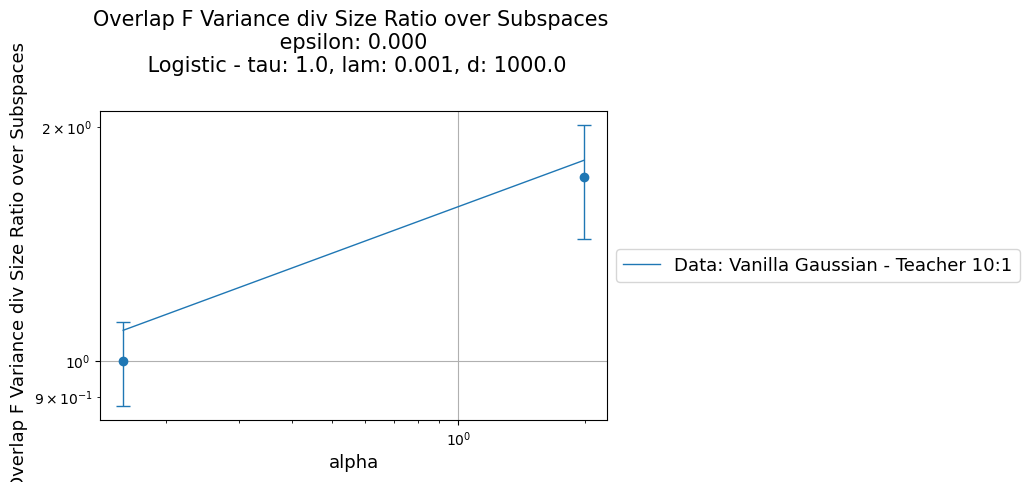

In [483]:
overlaps = ["m","q","A","N","P","F"]

nr_subspaces = 2
for overlap in overlaps:

    create_plot(df, f"Overlap {overlap} Variance div Size Ratio over Subspaces", f"{overlap}_ratio_state_evolution",f"{overlap}_ratio_erm" )
    # , fix_a_variable="data_model_name", variable_value=data_model_name 

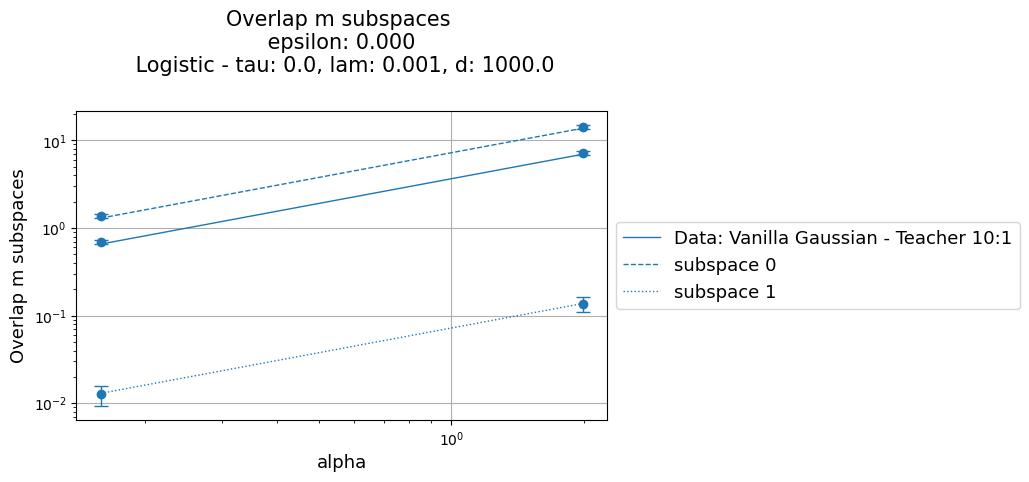

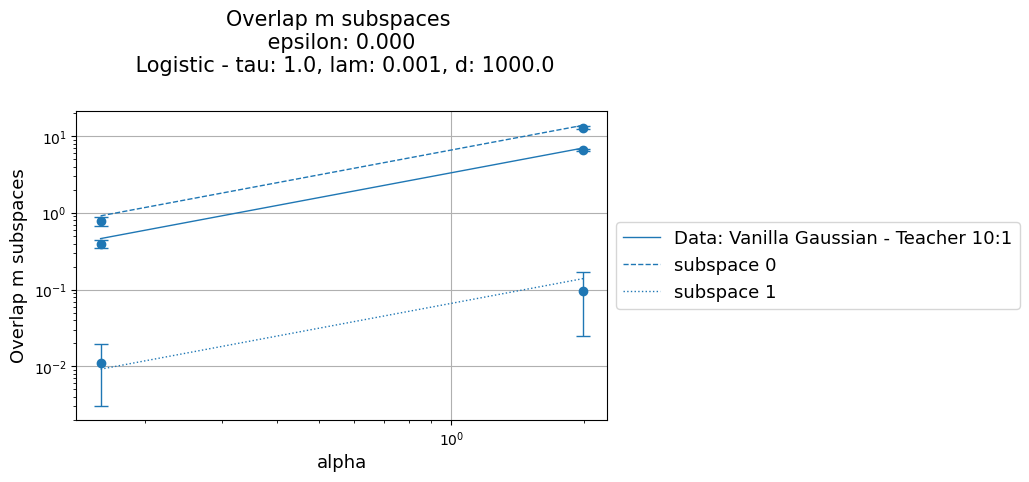

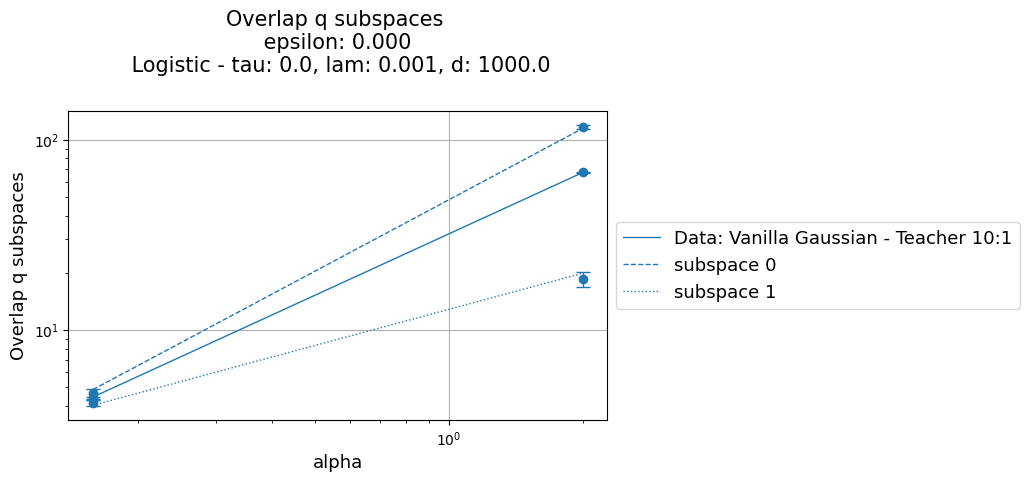

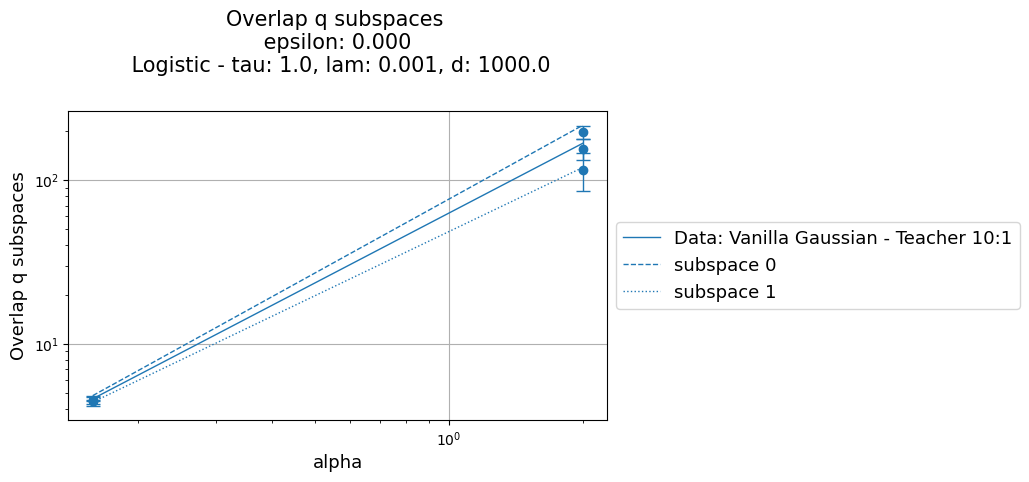

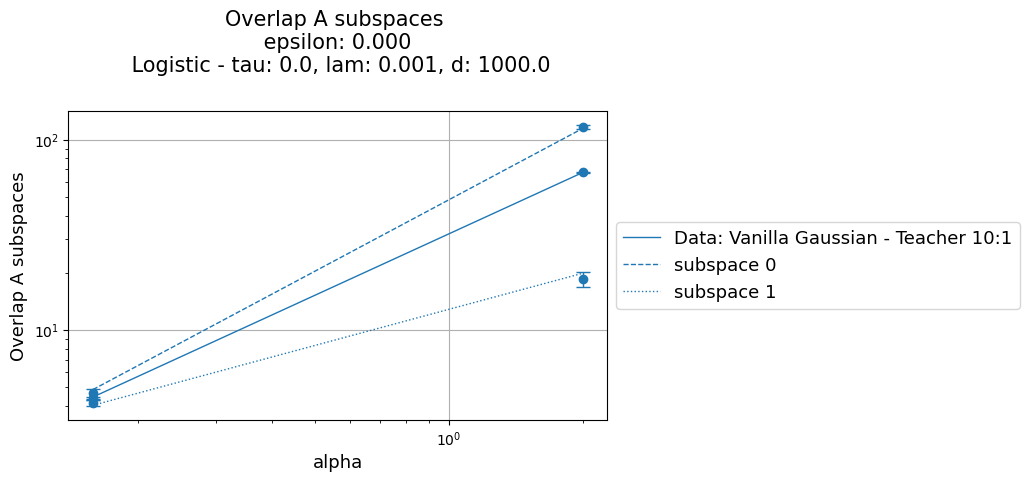

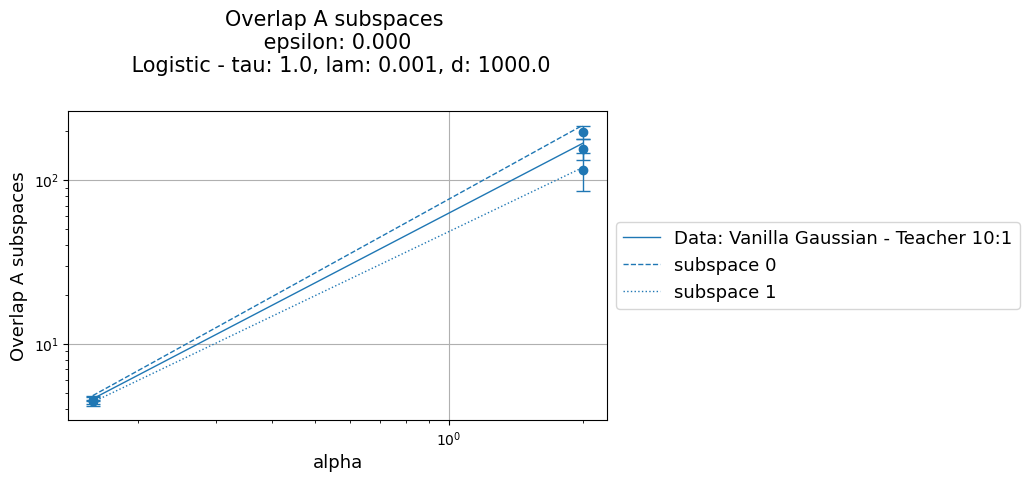

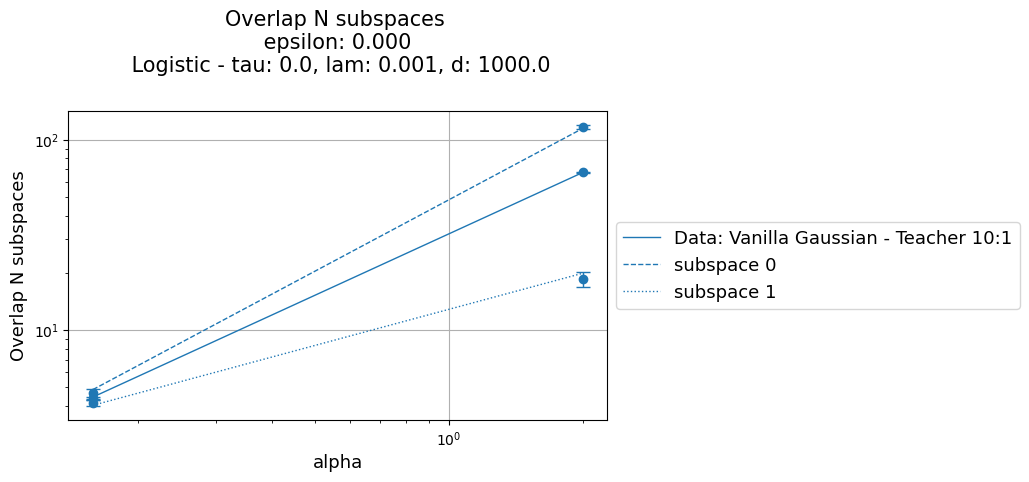

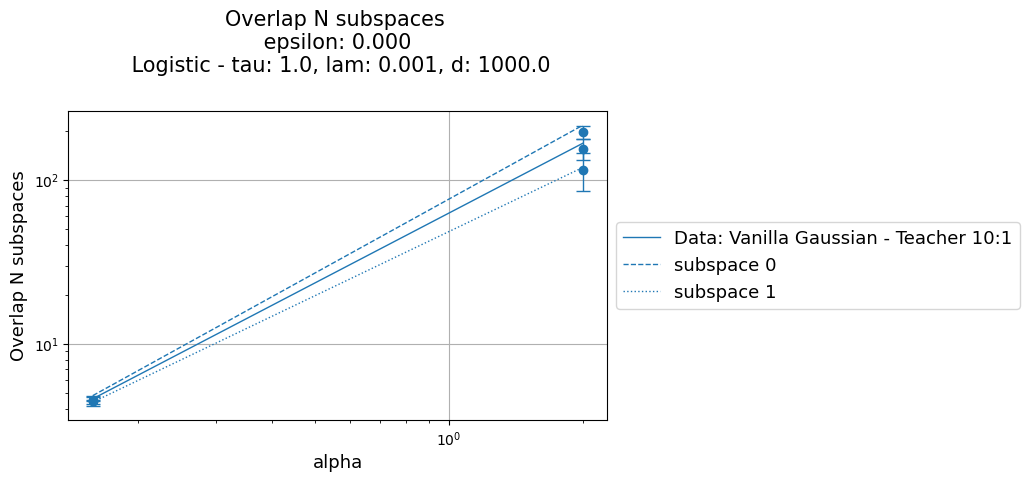

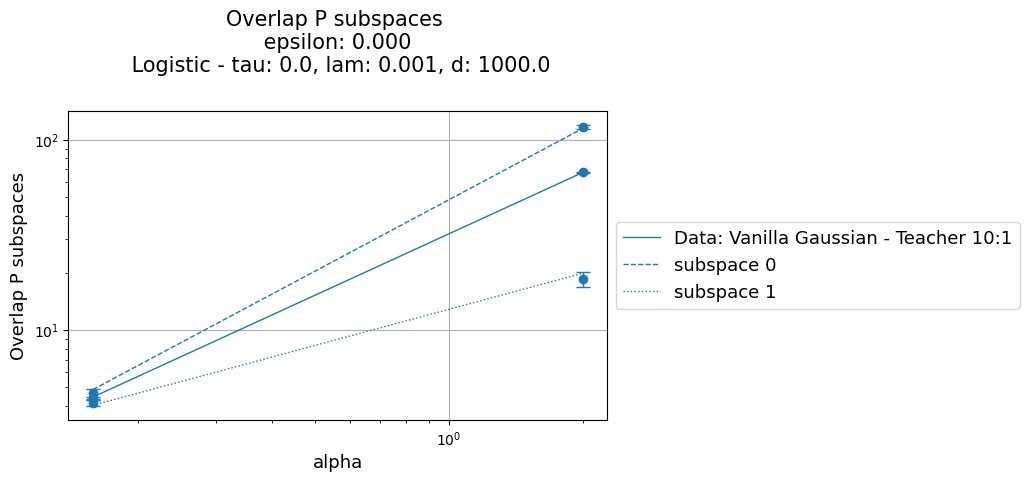

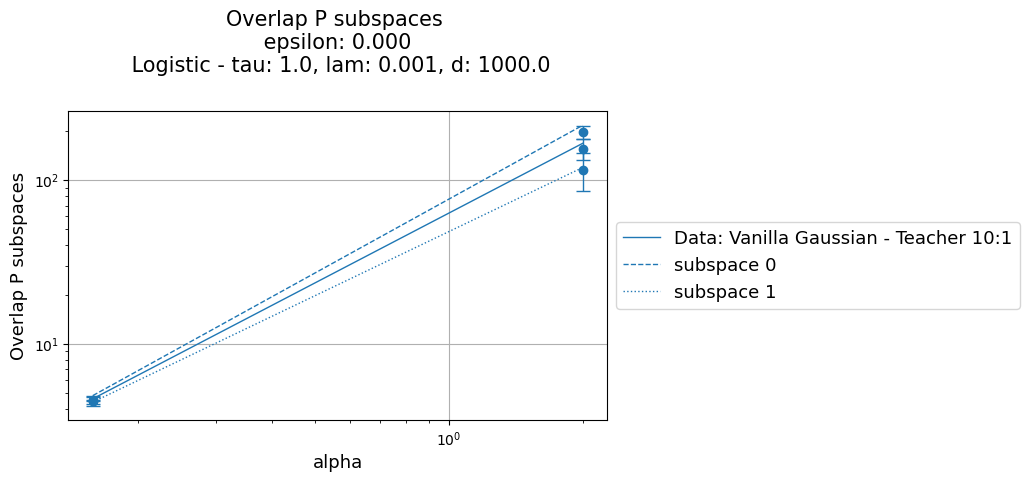

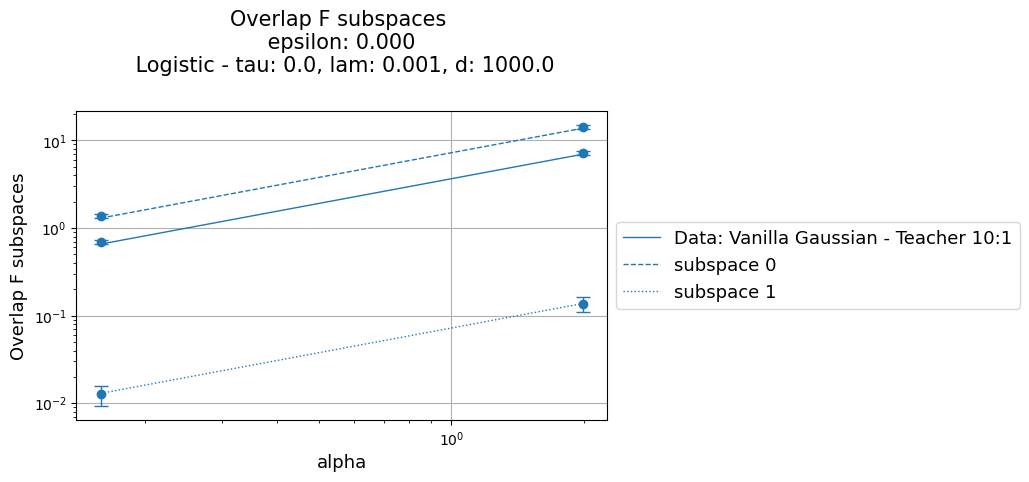

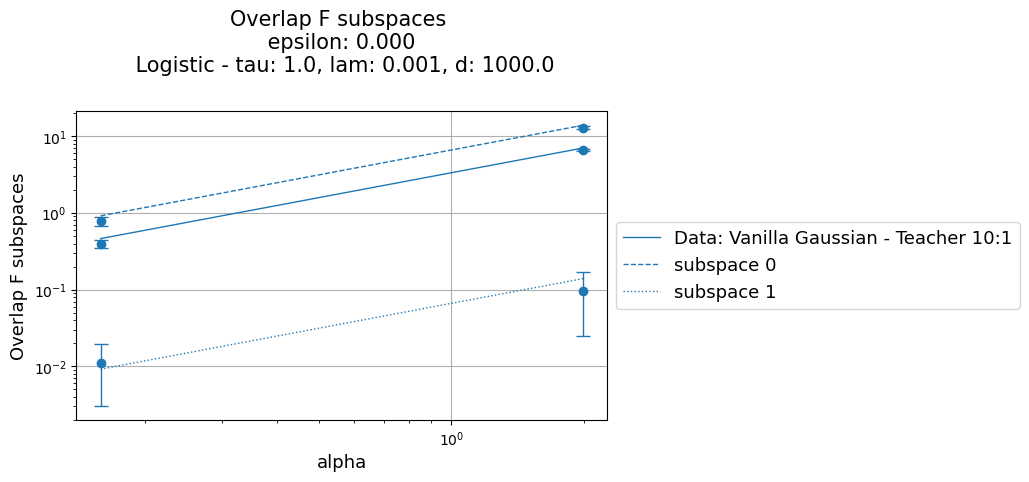

In [484]:
overlaps = ["m","q","A","N","P","F"]

# iterate over the data_models dict
# for data_model_key, data_model in data_models.items():
#     data_model_type = data_model_key[0]
#     data_model_name = data_model_key[1]

#     # check if data_model has attribute feature_sizes
#     if hasattr(data_model, "feature_sizes"):
#         feature_sizes = data_model.feature_sizes
#         nr_subspaces = len(feature_sizes)
#     else:
#         nr_subspaces = 1

nr_subspaces = 2
for overlap in overlaps:
    plot_additionally_gd = []
    plot_additionally_state_evolution = []
    plot_additionally_names = []
    for i in range(nr_subspaces):
        plot_additionally_gd.append(f"{overlap}_{i}_erm")
        plot_additionally_state_evolution.append(f"{overlap}_{i}_state_evolution")
        plot_additionally_names.append(f"subspace {i}")
    create_plot(df, f"Overlap {overlap} subspaces", f"{overlap}_state_evolution",f"{overlap}_erm",plot_additionally_gd=plot_additionally_gd,plot_additionally_state_evolution=plot_additionally_state_evolution,plot_additionally_names=plot_additionally_names )
    # , fix_a_variable="data_model_name", variable_value=data_model_name 
